# IBM Data Science Capstone Project
# Analysis of top-5 Volga Federal District cities in Russian Federation using Foursquare API
## by M. S. Mukhametzhanov

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Top-5 cities of the Volga Federal District are studied in this project. The Volga Federal District is one of the biggest districts in Russia consisting of 14 federal subjects with almost 30 million people in total. It is mainly placed along Volga, being the longest river in Europe. It has 5 cities with a population over 1 million: Nizhny Novgorod (rus. Нижний Новгород, the administrative centre of the district, population ~1.252 million people), Kazan (rus. Казань, population ~1.257 million people), Ufa (rus. Уфа, population ~1.128 million people), Samara (rus. Самара, population ~1.156 million people), Perm (rus. Пермь, population ~1.055 million people).

The main problem considered in this study can be briefly described as follows. 
1. Find the city of the Volga Federal District closest to Nizhny Novgorod in terms of public venues availability and their categories. 
2. In the chosen city, find the best places, where it is reasonable to open a restaurant based on known locations of the restaurants in the original city (Nizhny Novgorod).

Since Nizhny Novgorod is a big, grown and economically developed city, then the present study can be interesting to different businessmen who consider extending their business to other cities. In particular, there are several series of food restaurants, sushi bars, pizzerias, bars, etc. (they are not listed here only for privacy reasons). Moreover, the methodologies presented in this study are easily extendable to other regions and districts not only in Russia, but in other countries as well (e.g., in Europe, USA or Canada). In this case, only the Data section of the Jupyter notebook related to this study will differ.

All the methods used in the present study have been implemented in Python 3.7 using Jupyter notebooks in IBM Watson Studio. The complete notebook is presented in github. The following standard libraries have been mainly used during the work: pandas and numpy for all handlings with the data frames and data series, seaborn and matplotlib for visualizations, geopy and geocoder for obtaining the coordinates of the neighborhoods, json for handling json-files, folium for visualization of the maps, scikit-learn for clustering, and requests for working with the Foursquare API. 

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import pandas as pd
import numpy as np
#!pip install geocoder
#!pip install folium
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import geocoder # import geocoder
print('Libraries imported.')

Libraries imported.


In [3]:
df_districts = pd.read_html('https://en.wikipedia.org/wiki/Federal_districts_of_Russia')
df_districts = df_districts[0].iloc[:,1:]
df_districts.rename(columns = {df_districts.columns[0]: 'Federal district', df_districts.columns[1]: 'Establishment date', df_districts.columns[2]: 'Area (km2)', df_districts.columns[5]:'HDI(2017)',df_districts.columns[6]:'Nominal GDP (2017)(RUB/USD)[5]',df_districts.columns[7]: 'GDP per capita (2017)', df_districts.columns[8]: 'Federal subjects', df_districts.columns[9]: 'Administrative Centre'},inplace = True)
df_districts.drop(['Establishment date','Nominal GDP (2017)(RUB/USD)[5]','GDP per capita (2017)'], axis = 1, inplace = True)
df_districts.at[2,'Federal district']='Southern'
df_districts.at[2,'Population(2010 census)']='16141100'
df_districts['Population(2010 census)'] = df_districts['Population(2010 census)'].astype(int)
df_districts.sort_values(by = 'Population(2010 census)',ascending = False, inplace = True)
df_districts.set_index('Federal district',inplace = True)
df_districts

,Area (km2),Population(2010 census),Population density(per km2),HDI(2017),Federal subjects,Administrative Centre
Federal district,,,,,,
Central,650200,38438600,59.1,0.838,18,Moscow
Volga,1037000,29900400,28.8,0.797,14,Nizhny Novgorod
Siberian,4361800,17178298,3.9,0.788,10,Novosibirsk
Southern,427800,16141100,37.7,0.793,8,Rostov-on-Don
Northwestern,1687000,13583800,8.1,0.827,11,Saint Petersburg
Ural,1818500,12082700,6.6,0.833,6,Yekaterinburg
North Caucasian,170400,9496800,55.7,0.785,7,Pyatigorsk
Far Eastern,6952600,8371257,1.2,0.801,11,Vladivostok


## Data  <a name="data"></a>

The main methodology used in the present research is clustering of a city based on the information of all venues available for a neighborhood in a fixed radius. Since all chosen cities are well divided by neighborhoods based on their postal codes, which is a unique common criterion for different cities in Russian Federation, then we will use postal codes of each city as places around which the venues are searched. 
In this case, first, we need the following data for each chosen city:
1. List of all postal codes
2. Latitude and longitude associated with each postal code in order to make queries using Foursquare API. 

The list of all postal codes in Russia is available from the following link: http://download.geonames.org/export/zip/RU.zip
The information available in this zip-archive is well described in the respective readme file. In particular, for each postal code (obviously, unique), its place name (mostly consisting of the city’s name), estimated latitude and longitude are provided: 

In [4]:
# The code was removed by Watson Studio for sharing.

,country code,postal code,place name,admin name1,admin code1,admin name2,admin code2,admin name3,admin code3,latitude,longitude,accuracy
0,RU,385000,Майкоп,Адыгея Республика,1.0,NaN,NaN,NaN,NaN,44.8802,40.2166,1.0
1,RU,385001,Майкоп 1,Адыгея Республика,1.0,NaN,NaN,NaN,NaN,44.8802,40.2166,1.0
2,RU,385002,Майкоп 2,Адыгея Республика,1.0,NaN,NaN,NaN,NaN,44.8802,40.2166,1.0
3,RU,385003,Майкоп 3,Адыгея Республика,1.0,NaN,NaN,NaN,NaN,44.8802,40.2166,1.0
4,RU,385006,Майкоп 6,Адыгея Республика,1.0,NaN,NaN,NaN,NaN,44.8802,40.2166,1.0


However, the latitude and longitude for each postal code are estimated very roughly, because they coincide for many postal codes in each city. To solve this issue, let us use the Python’s Nominatim tool in geopy.geocoders library for retrieving the real coordinates for each postal code (and for each city location as well). The lists cities, cities_en, regions contain the names of the cities in russian, in english and the administrative region, where they are located, respectively. N.B. Only the first 5 cities/regions of these lists are related to the Volga Federal District (the other ones have been added for a possible extension of the present research).

In [5]:
cities = ['Нижний Новгород', 'Казань', 'Уфа', 'Самара','Пермь','Екатеринбург','Челябинск','Воронеж', 'Волгоград','Ростов-На-Дону']
regions = ['Нижегородская Область', 'Татарстан Республика', 'Башкортостан Республика','Самарская Область','Пермский Край', 'Свердловская Область','Челябинская Область', 'Воронежская Область','Волгоградская Область','Ростовская Область']
cities_en = ['Nizhny Novgorod', 'Kazan', 'Ufa', 'Samara', 'Perm', 'Ekaterinburg', 'Chelyabinsk','Voronezh',  'Volgograd', 'Rostov-On-Don']
number_of_cities = 5
##Run the following code if the notebook is launched the first time (i.e., the data has not been uploaded yet), the info has been already downloaded in the files
#for i in range(number_of_cities):
#    city = cities[i]
#    #df_city = df_collection_cities[city]
#    for pcode in df_collection_cities[city]['Postal Code']:
#        address = pcode+', '+cities_en[i]+', Russia'
#        try:
#            location = geolocator.geocode(address)
#            df_collection_cities[city].at[df_collection_cities[city]['Postal Code']==pcode,'Latitude']=location.latitude
#            df_collection_cities[city].at[df_collection_cities[city]['Postal Code']==pcode,'Longitude']=location.longitude
#            #df_nn_coord.at[df_nn_coord['pcode']==pcode,'lat']=location.latitude
#            #df_nn_coord.at[df_nn_coord['pcode']==pcode,'long']=location.longitude
#        except:
#            print('error in '+address+', coordinates have not been changed')
#    filename = cities_en[i][0:4]+'_postal_codes_coordinates.csv'
#    project.save_data(data=df_collection_cities[city].to_csv(index=False),file_name=filename,overwrite=True)
df_collection_cities = {}
df_cities_coordinates= pd.DataFrame(columns = ['city', 'Latitude', 'Longitude'])
geolocator = Nominatim(user_agent="PFO_explorer")
for i in range(number_of_cities):
    filename = cities_en[i][0:4]+'_postal_codes_coordinates.csv'
    body = client_1e7ffed86c124ea785256df61c776ec6.get_object(Bucket='courseraibmdscapstoneproject-donotdelete-pr-d45ghpa6lf5uhv',Key=filename)['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
    df_collection_cities[cities[i]] = pd.read_csv(body,header = 0)
    df_collection_cities[cities[i]].columns = ['Postal Code','Latitude','Longitude']
    df_collection_cities[cities[i]]['Postal Code']= df_collection_cities[cities[i]]['Postal Code'].astype(str)
    df_collection_cities[cities[i]]['Latitude']= df_collection_cities[cities[i]]['Latitude'].astype(float)
    df_collection_cities[cities[i]]['Longitude']= df_collection_cities[cities[i]]['Longitude'].astype(float)
    df_collection_cities[cities[i]].drop_duplicates(subset=['Latitude','Longitude'], keep='first', inplace=True)
    df_collection_cities[cities[i]].reset_index(inplace = True)
    df_collection_cities[cities[i]].drop('index',axis=1,inplace=True)
    print(df_collection_cities[cities[i]].shape[0], 'postal codes have been obtained in ', cities_en[i],':')
    display(df_collection_cities[cities[i]].head())
    address = cities_en[i]+', Russia'
    location = geolocator.geocode(address)
    df_cities_coordinates.loc[i]=[cities_en[i],location.latitude,location.longitude]
    if cities[i]=='Пермь':
        df_cities_coordinates.at[i] = ['Perm', 58.000000, 56.316666]
print('Coordinates of the cities have been also generated:')
df_cities_coordinates

100 postal codes have been obtained in  Nizhny Novgorod :


,Postal Code,Latitude,Longitude
0,603000,56.317042,43.994228
1,603001,56.328599,43.991916
2,603002,56.317991,43.946463
3,603003,56.353209,43.859960
4,603004,56.244075,43.871575


81 postal codes have been obtained in  Kazan :


,Postal Code,Latitude,Longitude
0,420000,55.805098,49.316231
1,420004,55.825944,49.023734
2,420005,55.739063,49.095470
3,420006,55.841776,49.033756
4,420008,55.791208,49.121794


80 postal codes have been obtained in  Ufa :


,Postal Code,Latitude,Longitude
0,450000,54.749521,55.947344
1,450001,54.742158,55.985863
2,450002,54.732599,55.967544
3,450003,54.740759,55.917165
4,450004,54.516838,55.899858


83 postal codes have been obtained in  Samara :


,Postal Code,Latitude,Longitude
0,443000,53.229038,50.219392
1,443001,53.199232,50.119575
2,443003,53.215733,50.139756
3,443004,53.135122,50.091088
4,443006,53.202704,50.108773


65 postal codes have been obtained in  Perm :


,Postal Code,Latitude,Longitude
0,614000,58.010610,56.247974
1,614002,57.996483,56.266310
2,614006,58.010725,56.232251
3,614007,58.005173,56.264814
4,614010,57.988634,56.249074


Coordinates of the cities have been also generated:


,city,Latitude,Longitude
0,Nizhny Novgorod,56.328571,44.003506
1,Kazan,55.782355,49.124227
2,Ufa,54.726141,55.947499
3,Samara,53.198627,50.113987
4,Perm,58.000000,56.316666


The Folium map of the Volga Federal District with the selected cities using their coordinated calculated above is presented below.

In [6]:
mean_lat = df_cities_coordinates['Latitude'].mean()
mean_lon = df_cities_coordinates['Longitude'].mean()
map_pfo = folium.Map(location=[mean_lat, mean_lon], zoom_start=5,tiles='Stamen Terrain')
df = pd.read_html('https://en.wikipedia.org/wiki/Volga_Federal_District')
!wget --quiet https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/russia.geojson
rus_geo = r'russia.geojson' # geojson file
with open(rus_geo,'r') as f:
  mydata = json.load(f)
n_regions = len(mydata['features'])
pfo_regions = []
pfo_regions_names = df[1]['Federal subject'].tolist()
for i in range(n_regions):
    if mydata['features'][i]['properties']['name_latin'] in pfo_regions_names:
        pfo_regions.append(mydata['features'][i]['properties']['name_latin'])
        map_pfo.choropleth(geo_data=mydata['features'][i],fill_color='blue', fill_opacity=0.2, line_opacity=0.1)
if (np.sort(pfo_regions)==np.sort(pfo_regions_names)).all():
    print('Regions coincide, OK')
else:
    print('something wrong, check the regions')
for lat, lng, city in zip(df_cities_coordinates['Latitude'], df_cities_coordinates['Longitude'], df_cities_coordinates['city']):
    #label = '{}, {}'.format(neighborhood, borough)
    label = city
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False,default_open=True).add_to(map_pfo)  
map_pfo


Regions coincide, OK


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


The folium map of Nizhny Novgorod covered by the neighborhoods defined through the postal code is presented below. Here, each neighborhood is represented by a circle of a fixed radius. The radius of 1000 metres has been chosen for each neighborhood (this radius will be used in the Foursquare API for searching the venues), since, on the one hand, it becomes sufficient to cover the city, and, on the other hand, a venue located in 1000 metres is accessible even by walking. 

In [7]:
#df_collection_cities['Нижний Новгород']
city_index = 0
city = cities[city_index]
city_en = cities_en[city_index]
map_nn = folium.Map(location=[df_cities_coordinates[df_cities_coordinates['city']==city_en].Latitude, df_cities_coordinates[df_cities_coordinates['city']==city_en].Longitude], zoom_start=11)
# add markers to map
for lat, lng, pcode in zip(df_collection_cities[city]['Latitude'], df_collection_cities[city]['Longitude'], df_collection_cities[city]['Postal Code']):
    #label = '{}, {}'.format(neighborhood, borough)
    label = pcode
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nn)  
map_nn

Generate credentials for the Foursquare API (they are downloaded from the respective configuration file, closed for privacy)

In [8]:
# The code was removed by Watson Studio for sharing.

Credentials generated:
CLIENT_ID, CLIENT_SECRET, VERSION, LIMIT


Request all venue categories from Foursquare. For each macro category, the respective sub-categories are saved into the respective dictionary

In [9]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
results = requests.get(url).json()['response']['categories']
n_cat = len(results)
main_categories = pd.DataFrame(columns = ['name','id'])
main_categories_dict = {}
for categ in range(n_cat):
    cat_id = results[categ]['id']
    main_categories.at[categ] = [results[categ]['name'], cat_id]
    main_categories_dict[cat_id] = []
    stack_subcat = []
    subcat = results[categ]['categories']
    main_categories_dict[cat_id].append(results[categ]['name']) 
    if subcat:
        for i in range(len(subcat)):
            stack_subcat.append(subcat[i])
    while stack_subcat:
        subcat = stack_subcat.pop()
        main_categories_dict[cat_id].append(subcat['name']) 
        if subcat['categories']:
            for i in range(len(subcat['categories'])):
                stack_subcat.append(subcat['categories'][i])
    #print(results[categ]['name']+' (id '+results[categ]['id']+'),')
main_categories.set_index('id',inplace = True)
main_categories

,name
id,
4d4b7104d754a06370d81259,Arts & Entertainment
4d4b7105d754a06372d81259,College & University
4d4b7105d754a06373d81259,Event
4d4b7105d754a06374d81259,Food
4d4b7105d754a06376d81259,Nightlife Spot
4d4b7105d754a06377d81259,Outdoors & Recreation
4d4b7105d754a06375d81259,Professional & Other Places
4e67e38e036454776db1fb3a,Residence
4d4b7105d754a06378d81259,Shop & Service


An example of the first 5 sub-categories for the macro category Arts & Entertainment:

In [10]:
main_categories_dict[main_categories.index[main_categories['name']=='Arts & Entertainment'][0]][0:5]

['Arts & Entertainment', 'Zoo', 'Zoo Exhibit', 'Water Park', 'VR Cafe']

Let us define the function for getting all venues accessible from each neighborhood for each city:

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Apply the function defined above for obtaining the venues accessible from each neighborhood in each city. The results will be written in the following three dictionaries (the keys of the dictionaries are the english names of the cities):
1. all_venues_dict -- the dictionary containing, for each city (the dict's key), all venues available from each neighborhood in distance of 1000 metres, with their micro and macro categories.
2. onehot_dict -- the dictionary containing, for each city (the dict's key), the dummies for each venue macro category (expressed simply as Venue Category).
3. grouped_dict -- the dictionary containing, for each city (the dict's key), the relative number of venues accessible from each neighborhood, grouped by neighborhoods.

Only significant categories are considered here: since there is no sufficient information about the venues of the categories Event, Residence, College & University, and Professional & Other Places, then these categories are excluded.

In [12]:
#### Run the following code, if the notebook is launched the first time: it generates the venues and writes them into separate csv-files in the project directory
#for city_index in range(1,number_of_cities):
#    #city_index = 0
#    city = cities[city_index]
#    city_en = cities_en[city_index]
#    myvenues = getNearbyVenues(names=df_collection_cities[city]['Postal Code'], latitudes=df_collection_cities[city]['Latitude'], longitudes=df_collection_cities[city]['Longitude'], radius = 1000)
#    filename = city_en+'_venues.csv'
#    project.save_data(data=myvenues.to_csv(index=False),file_name=filename,overwrite=True)

In [13]:
all_venues_dict = {}
onehot_dict = {}
grouped_dict = {}
cat_ids = list(main_categories_dict.keys())
for city_index in range(number_of_cities):
    city = cities[city_index]
    city_en = cities_en[city_index]
    filename = city_en+'_venues.csv'
    body = client_1e7ffed86c124ea785256df61c776ec6.get_object(Bucket='courseraibmdscapstoneproject-donotdelete-pr-d45ghpa6lf5uhv',Key=filename)['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
    all_venues_dict[city_en] = pd.read_csv(body,header = 0)
    all_venues_dict[city_en]['Neighborhood']=all_venues_dict[city_en]['Neighborhood'].astype(str)
    all_venues_dict[city_en].rename(columns={'Venue Category': 'Venue Micro Category'},inplace = True)
    for venues_index in all_venues_dict[city_en].index: 
        for macro_cat in cat_ids:
            if all_venues_dict[city_en].loc[venues_index,'Venue Micro Category'] in main_categories_dict[macro_cat]:
                all_venues_dict[city_en].at[venues_index,'Venue Category'] =  main_categories.loc[macro_cat]['name']
                break
    all_venues_dict[city_en].drop_duplicates(subset=list(all_venues_dict[city_en].columns)[1:], keep='first', inplace=True)
    all_venues_dict[city_en].reset_index(inplace = True)
    all_venues_dict[city_en].drop('index',axis=1,inplace=True)
    print('There are {} unique categories in {}.'.format(len(all_venues_dict[city_en]['Venue Category'].unique()),city_en))
    # one hot encoding
    onehot_dict[city_en] = pd.DataFrame()
    onehot_dict[city_en] = pd.get_dummies(all_venues_dict[city_en][['Venue Category']], prefix="", prefix_sep="")
    # add neighborhood column back to dataframe
    onehot_dict[city_en]['Neighborhood'] = all_venues_dict[city_en]['Neighborhood'] 
    # move neighborhood column to the first column
    ind_nei = onehot_dict[city_en].columns.tolist().index('Neighborhood');
    fixed_columns = [onehot_dict[city_en].columns[ind_nei]]+list(onehot_dict[city_en].columns[0:ind_nei])+list(onehot_dict[city_en].columns[ind_nei+1:])
    onehot_dict[city_en] = onehot_dict[city_en][fixed_columns]
    columns = onehot_dict[city_en].groupby('Neighborhood').sum().sum().index[onehot_dict[city_en].groupby('Neighborhood').sum().sum()>50].tolist()
    print('The shape of the onehot_dict[',city_en,']:', onehot_dict[city_en].shape)
    grouped_dict[city_en] = onehot_dict[city_en].groupby('Neighborhood').sum().div(onehot_dict[city_en].sum()[1:]).reset_index()
    print('The shape of the grouped_dict[',city_en,']:', grouped_dict[city_en].shape)
display(all_venues_dict[cities_en[0]].head())

There are 9 unique categories in Nizhny Novgorod.
The shape of the onehot_dict[ Nizhny Novgorod ]: (2226, 10)
The shape of the grouped_dict[ Nizhny Novgorod ]: (100, 10)
There are 8 unique categories in Kazan.
The shape of the onehot_dict[ Kazan ]: (2262, 9)
The shape of the grouped_dict[ Kazan ]: (80, 9)
There are 9 unique categories in Ufa.
The shape of the onehot_dict[ Ufa ]: (2544, 10)
The shape of the grouped_dict[ Ufa ]: (76, 10)
There are 8 unique categories in Samara.
The shape of the onehot_dict[ Samara ]: (2668, 9)
The shape of the grouped_dict[ Samara ]: (83, 9)
There are 9 unique categories in Perm.
The shape of the onehot_dict[ Perm ]: (1676, 10)
The shape of the grouped_dict[ Perm ]: (64, 10)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Micro Category,Venue Category
0,603000,56.317042,43.994228,Burrito Family,56.316153,43.992785,Burrito Place,Food
1,603000,56.317042,43.994228,Franky Bar,56.316330,43.994536,Cocktail Bar,Nightlife Spot
2,603000,56.317042,43.994228,Surf Coffee,56.317038,43.994256,Coffee Shop,Food
3,603000,56.317042,43.994228,Большая Покровская улица,56.320291,43.998442,Road,Travel & Transport
4,603000,56.317042,43.994228,Бикрам-Йога | Нижний Новгород,56.319637,43.994256,Yoga Studio,Outdoors & Recreation


Count the number of venues in each category for each city and delete venues related to the categories, where there are almost no venues:

In [14]:
df_temp = pd.DataFrame(columns = ['Category']+cities_en[0:number_of_cities])
for city_n in range(5):
    df_temp2 = pd.DataFrame(onehot_dict[cities_en[city_n]].groupby('Neighborhood').sum().sum())
    for cat_n in range(len(list(main_categories['name']))):
        df_temp.at[cat_n,'Category'] = list(main_categories['name'])[cat_n]
        if list(main_categories['name'])[cat_n] in list(df_temp2.index):
            df_temp.at[cat_n,cities_en[city_n]]=df_temp2.loc[list(main_categories['name'])[cat_n]][0]
        else:
            df_temp.at[cat_n,cities_en[city_n]]=0
df_temp.at[len(list(main_categories['name']))] = ['Total']+list(df_temp.iloc[0:10,1:].sum())
df_temp.set_index('Category',inplace = True)
display(df_temp)
for city_index in range(number_of_cities):
    city_en = cities_en[city_index]
    columns = onehot_dict[city_en].groupby('Neighborhood').sum().sum().index[onehot_dict[city_en].groupby('Neighborhood').sum().sum()>50].tolist()
    onehot_dict[city_en] = onehot_dict[city_en][['Neighborhood']+columns]
    grouped_dict[city_en] = onehot_dict[city_en].groupby('Neighborhood').sum().div(onehot_dict[city_en].sum()[1:]).reset_index()

,Nizhny Novgorod,Kazan,Ufa,Samara,Perm
Category,,,,,
Arts & Entertainment,209,203,261,157,125
College & University,5,3,4,3,1
Event,0,0,0,0,0
Food,685,813,654,882,697
Nightlife Spot,143,148,182,123,129
Outdoors & Recreation,288,282,308,311,201
Professional & Other Places,9,30,20,12,11
Residence,1,0,3,0,3
Shop & Service,586,603,877,966,409


Count the number of venues in each category for each city after the cleaning:

In [15]:
df_temp = pd.DataFrame(columns = ['City']+columns+['Total'])
for city_n in range(5):
    df_temp2 = pd.DataFrame(onehot_dict[cities_en[city_n]].groupby('Neighborhood').sum().sum())
    #df_temp = pd.DataFrame()
    df_temp.at[city_n] = [cities_en[city_n],0,0,0,0,0,0,0]
    df_temp.at[city_n,'Total'] = df_temp2.iloc[:,0].sum()
    for i in range(len(df_temp2.index)):
        df_temp.at[city_n,df_temp2.index[i]] = df_temp2.iloc[i,0]
df_temp.rename({'City':'Category\City'},axis = 1,inplace = True)
df_temp.set_index('Category\City',inplace = True)
df_temp = df_temp.transpose()
df_temp

Category\City,Nizhny Novgorod,Kazan,Ufa,Samara,Perm
Arts & Entertainment,209,203,261,157,125
Food,685,813,654,882,697
Nightlife Spot,143,148,182,123,129
Outdoors & Recreation,288,282,308,311,201
Shop & Service,586,603,877,966,409
Travel & Transport,300,180,235,214,100
Total,2211,2229,2517,2653,1661


Count the relative number of venues in each category for each city, RMS deviations w.r.t. Nizhny Novgorod of the obtained relative numbers and the barplots visualizing the obtained results

Relative number of venues in each category in % for each city:


Category\City,Nizhny Novgorod,Kazan,Ufa,Samara,Perm
Arts & Entertainment,9.5,9.1,10.4,5.9,7.5
Food,31,36.5,26,33.2,42
Nightlife Spot,6.5,6.6,7.2,4.6,7.8
Outdoors & Recreation,13,12.7,12.2,11.7,12.1
Shop & Service,26.5,27.1,34.8,36.4,24.6
Travel & Transport,13.6,8.1,9.3,8.1,6


Root mean square deviations w.r.t. Nizhny Novgorod for each city:


,RMS w.r.t. Nizhny Novgorod
City,
Kazan,3.19166
Ufa,4.36501
Samara,5.02262
Perm,5.61056


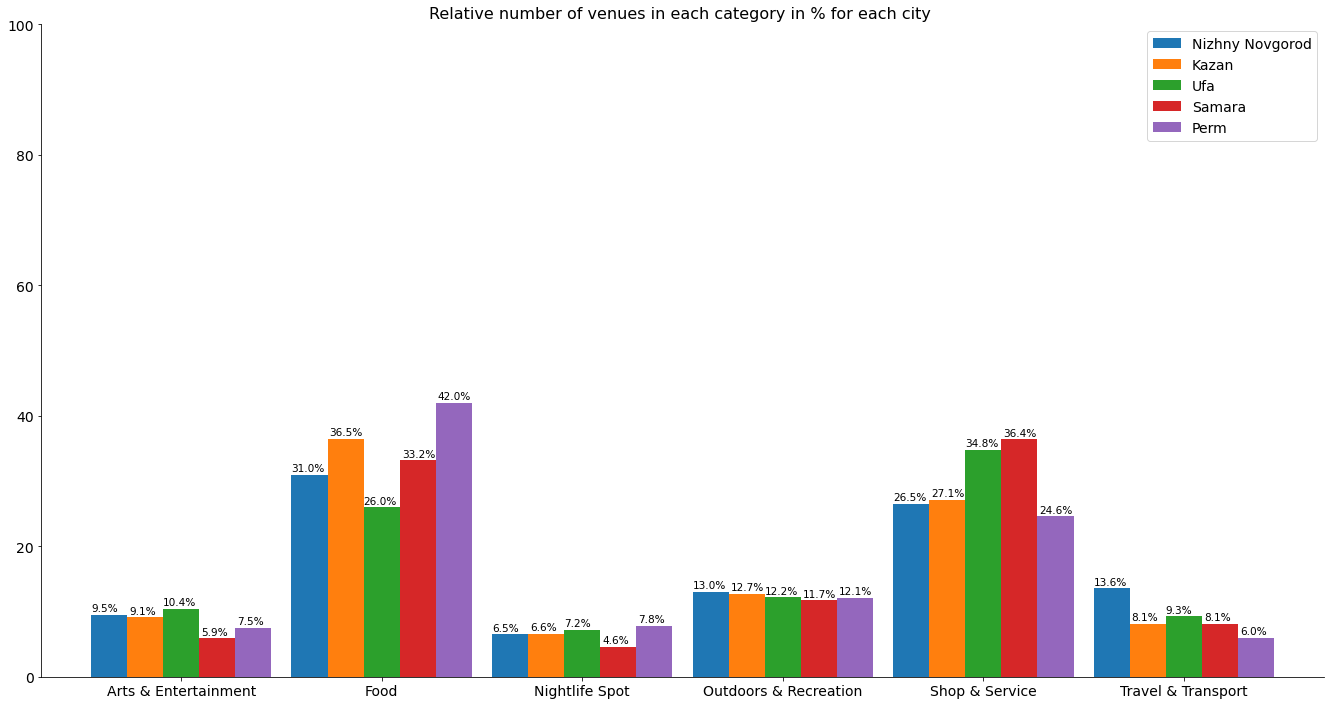

In [16]:
df_temp = pd.DataFrame(columns = ['City']+columns)
for city_n in range(5):
    df_temp2 = pd.DataFrame(onehot_dict[cities_en[city_n]].groupby('Neighborhood').sum().sum())
    df_temp.at[city_n] = [cities_en[city_n],0,0,0,0,0,0,]
    for i in range(len(df_temp2.index)):
        df_temp.at[city_n,df_temp2.index[i]] = round(100*df_temp2.iloc[i,0]/df_temp2.iloc[:,0].sum(),1)
df_temp.rename({'City':'Category\City'},axis = 1,inplace = True)
df_temp.set_index('Category\City',inplace = True)
df_temp2 = df_temp.transpose()

df_temp_dist = pd.DataFrame(columns = ['City','RMS w.r.t. Nizhny Novgorod'])
#df_temp_dist.set_index('City',inplace = True)
for city_n in range(1,5):
    x = np.array(list(df_temp2[cities_en[city_n]]-df_temp2[cities_en[0]]))
    df_temp_dist.at[city_n-1,'City'] = cities_en[city_n]
    df_temp_dist.at[city_n-1,'RMS w.r.t. Nizhny Novgorod'] = np.sqrt(np.mean(x**2))
ax = df_temp2.plot(kind = 'bar', stacked=False, figsize=(23, 12), width = 0.9,fontsize = 14,rot=0)
df_temp_dist.set_index('City',inplace = True)
print('Relative number of venues in each category in % for each city:')
display(df_temp2)
print('Root mean square deviations w.r.t. Nizhny Novgorod for each city:')
display(df_temp_dist)
ax.set_title('Relative number of venues in each category in % for each city ',size = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize = 14)
ax.set_ylim([0,100])
for i in range(6):
    label1 = df_temp2.iloc[i,0]
    ax.text(x = i-0.45,y=label1+0.5,s = str(label1)+'%',fontsize=10.5)
    label1 = df_temp2.iloc[i,1]
    ax.text(x = i-0.26,y=label1+0.5,s = str(label1)+'%',fontsize=10.5)
    label1 = df_temp2.iloc[i,2]
    ax.text(x = i-0.09,y=label1+0.5,s = str(label1)+'%',fontsize=10.5)
    label1 = df_temp2.iloc[i,3]
    ax.text(x = i+0.1,y=label1+0.5,s = str(label1)+'%',fontsize=10.5)
    label1 = df_temp2.iloc[i,4]
    ax.text(x = i+0.28,y=label1+0.5,s = str(label1)+'%',fontsize=10.5)

## Methodology <a name="methodology"></a>

### Exploratory data analysis

Let us visualize the box plots of the relative number of venues for all neighborhoods in Nizhny Novgorod in order to understand if there are some biases related to a heterogeneous structure of the city

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
0,603000,0.033493,0.062774,0.062937,0.031250,0.032423,0.036667
1,603001,0.076555,0.051095,0.104895,0.034722,0.010239,0.026667
2,603002,0.019139,0.011679,0.000000,0.010417,0.023891,0.020000
3,603003,0.014354,0.014599,0.006993,0.017361,0.010239,0.003333
4,603004,0.009569,0.011679,0.000000,0.017361,0.008532,0.010000


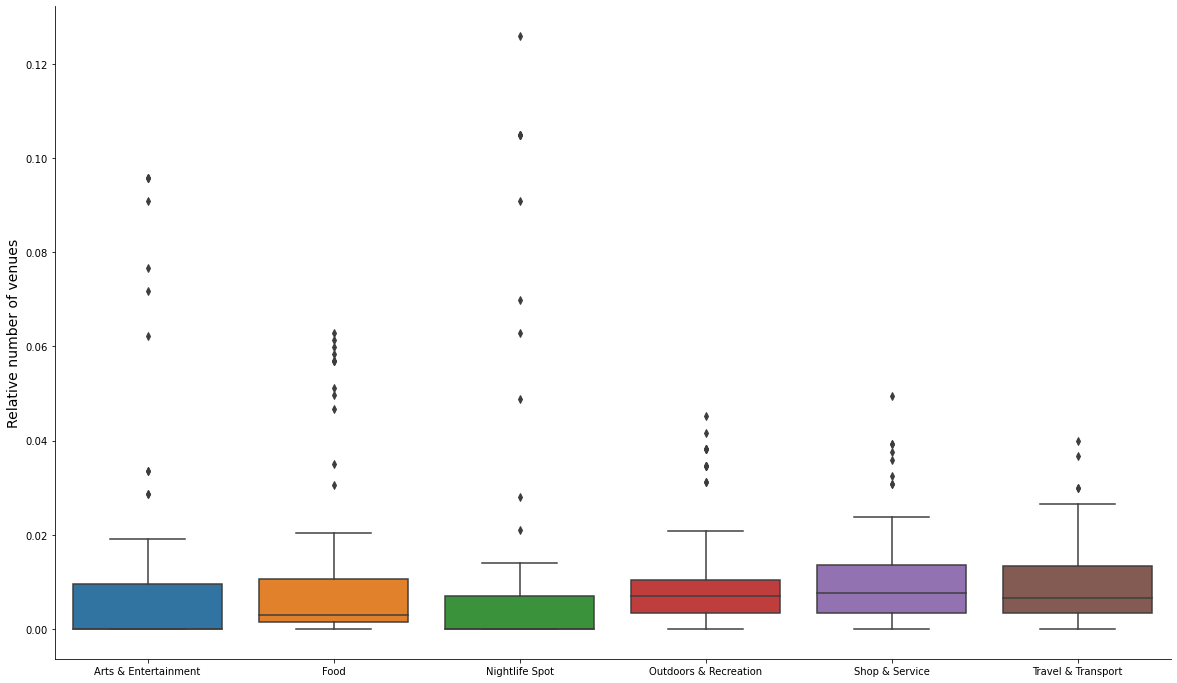

In [17]:
fig, ax = plt.subplots()
sns.boxplot(data = grouped_dict['Nizhny Novgorod'].drop('Neighborhood',axis = 1,inplace = False),ax = ax)
fig.set_size_inches(20, 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Relative number of venues', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
grouped_dict['Nizhny Novgorod'].head()

We see that there are high biases in almost all the categories: the Nizhny Novgorod city is not homogeneous and definitely should be clustered into different parts. Let us see the scatter plots Category vs. Category (for all venue categories) in order to substantiate this claim.

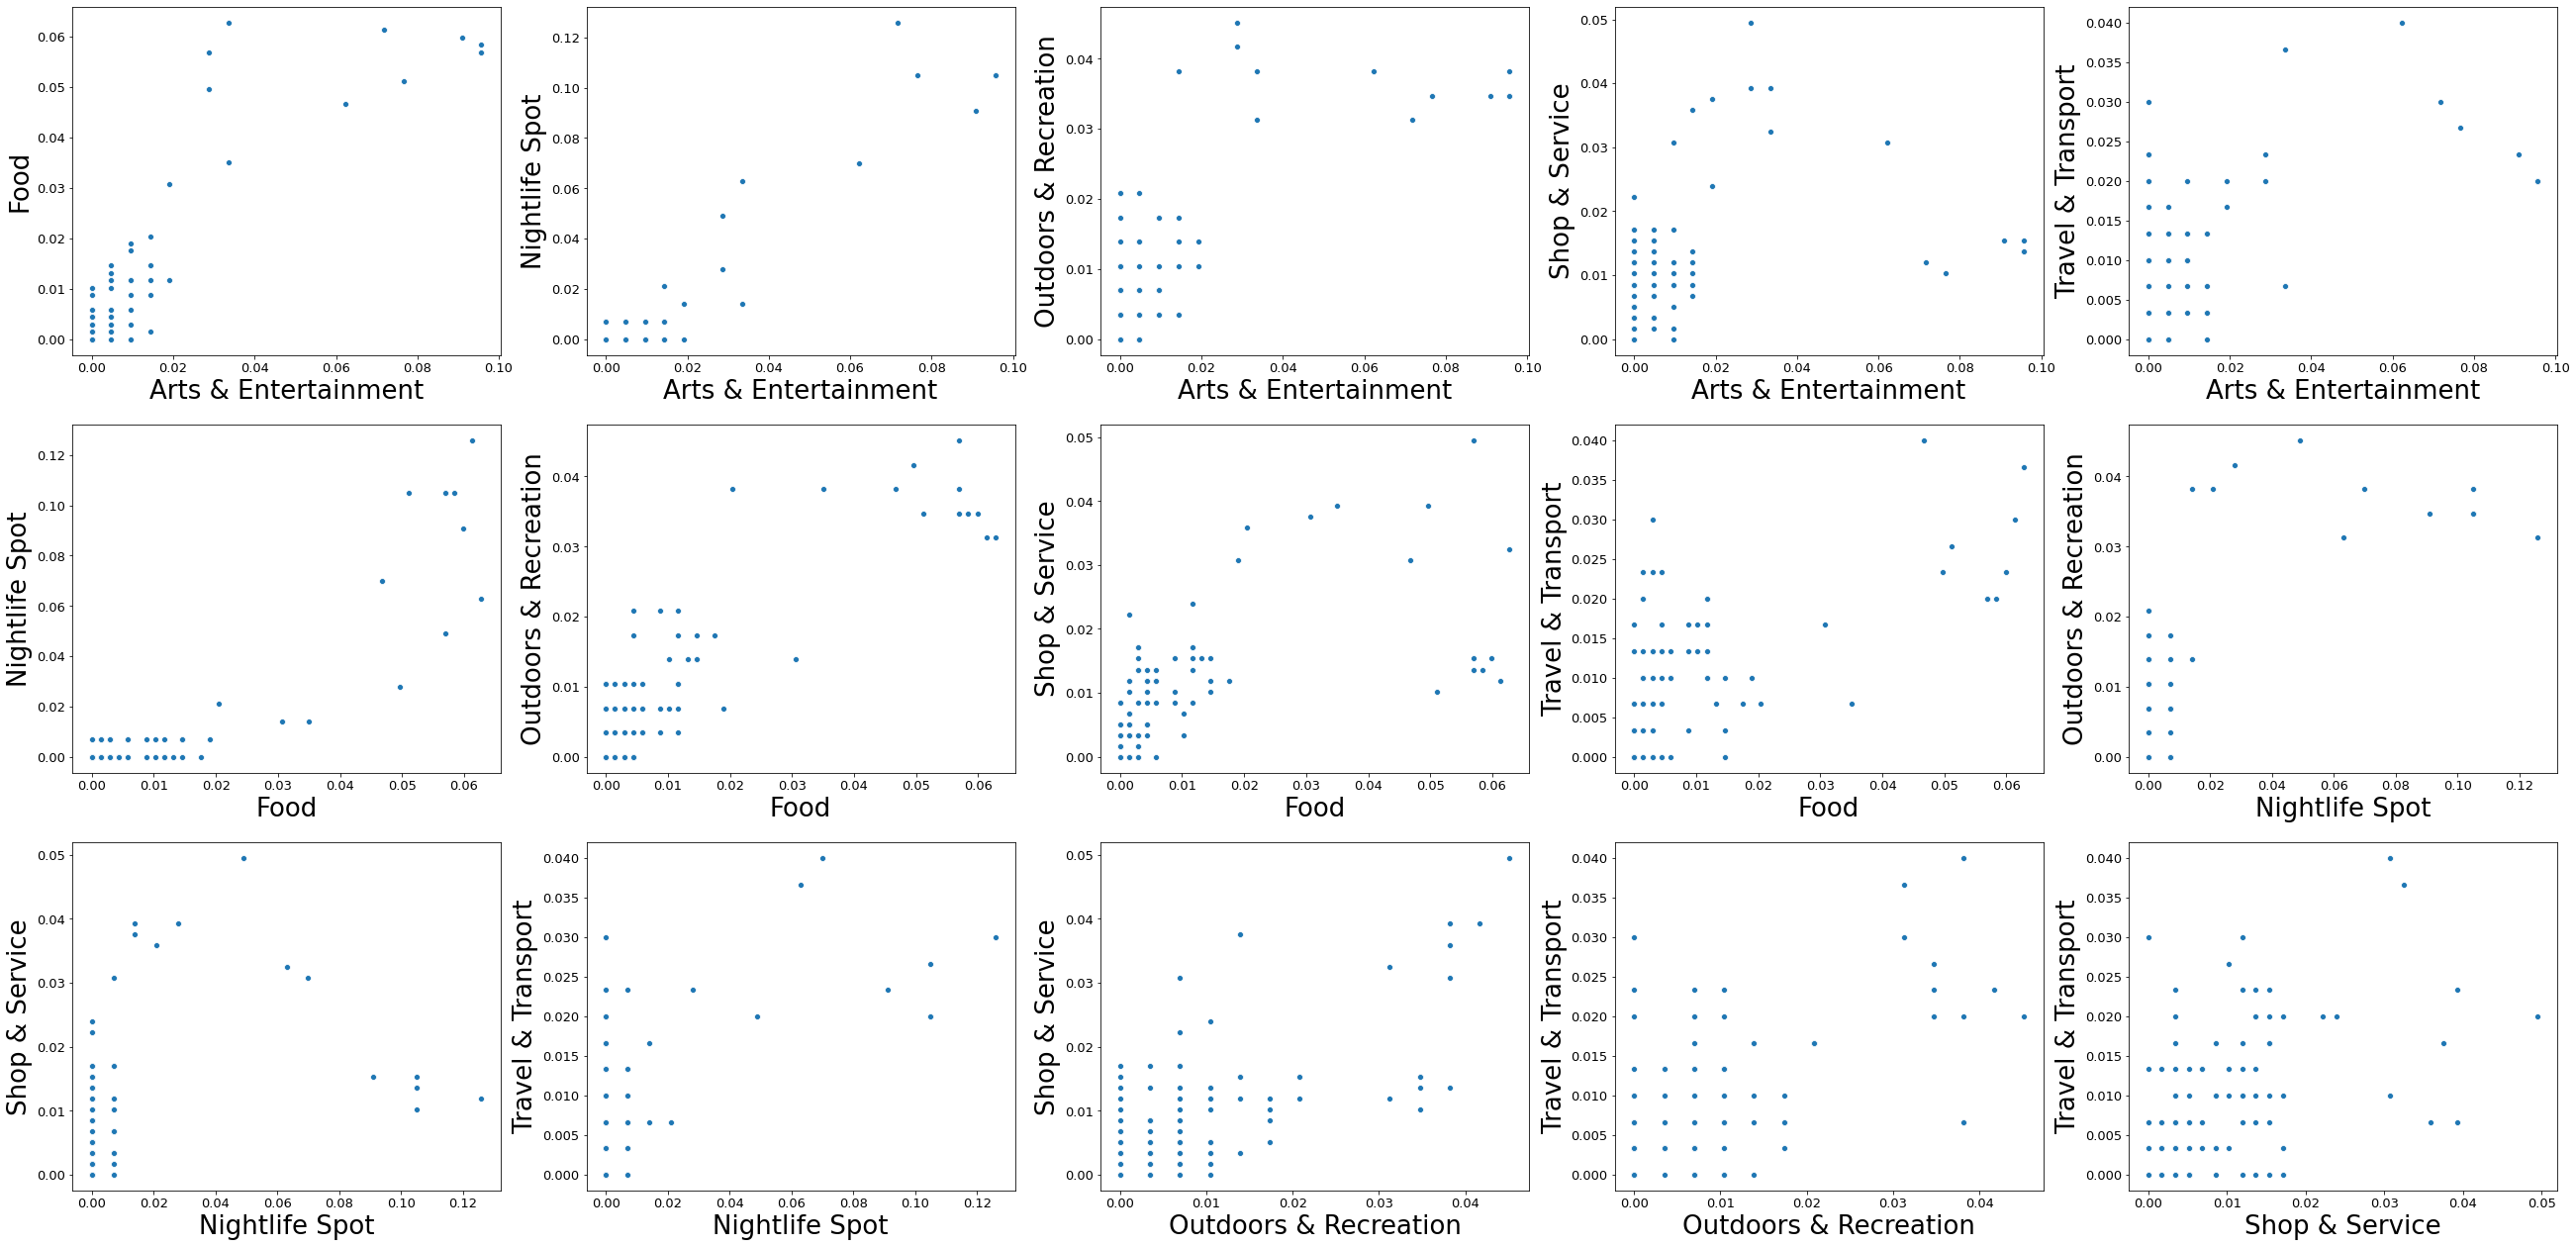

In [18]:
city_en = cities_en[0]
cols = list(grouped_dict[city_en].columns)
cols.remove('Neighborhood')
fsize = 13
fig, axs = plt.subplots(3,5,figsize=(45,22))
axs_pos = [(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4),(2,0),(2,1),(2,2),(2,3),(2,4)]
axs_idx = 0
for col1 in range(len(cols)-1):    
    for col2 in range(col1+1,len(cols)):
        ax1 = axs[axs_pos[axs_idx][0],axs_pos[axs_idx][1]]
        sns.scatterplot(x=grouped_dict[city_en][cols[col1]],y=grouped_dict[city_en][cols[col2]],ax=ax1)
        ax1.tick_params(labelsize=fsize,rotation=0)
        #ax1.set_title('Scatter plot '+cols[col1] + ' vs. '+cols[col2])
        ax1.set_xlabel(cols[col1], fontsize=fsize*2)
        ax1.set_ylabel(cols[col2], fontsize=fsize*2)
        axs_idx = axs_idx+1


### Clustering

The clustering is performed in 6-dimensional space, since there are 6 venues categories in our dataset. Each point (or a row in our dataset) is represented by the postal code and 6 numeric values of the range (0,1) being the relative number of venues in each category around the neighborhood defined through the postal code. As we see from the previous figure for Nizhny Novgorod, there is no evidence for special structures or non-convex patterns in the data, so the standard K-means method can be performed for the clustering. There is only one control parameter in this method: the number of clusters k. In order to determine an optimal value of k, let us use the Elbow method, which consists of clustering each city with different k from 1 to 10 and then choosing an optimal k for each city, visually showing the obtained inertia for each value of k. 

First, let us define the function clustering the city into n clusters (at the end, the clusters are sorted according to their average value of the average relative number of venues of each category within each cluster):

In [19]:
def cluster_city(nclusters, city):
    grouped_clustering = grouped_dict[city_en].drop('Neighborhood', 1)
    kmeans = KMeans(n_clusters=nclusters, random_state=1).fit(grouped_clustering)
    clusters_unsorted = []
    clusters_sorted = []
    for i in range(nclusters):
        clusters_unsorted.append(grouped_clustering.loc[kmeans.labels_ == i].mean().mean())
    clusters_sorted = np.sort(clusters_unsorted)[::-1]
    cluster_labels = np.copy(kmeans.labels_)
    for i in range(nclusters):
        cluster_labels[kmeans.labels_==clusters_unsorted.index(clusters_sorted[i])] = i
    kmeans.labels_ = cluster_labels
    return kmeans

Now, let us visualize the graphs of the obtained inertia values vs. the number of clusters (up to 10).

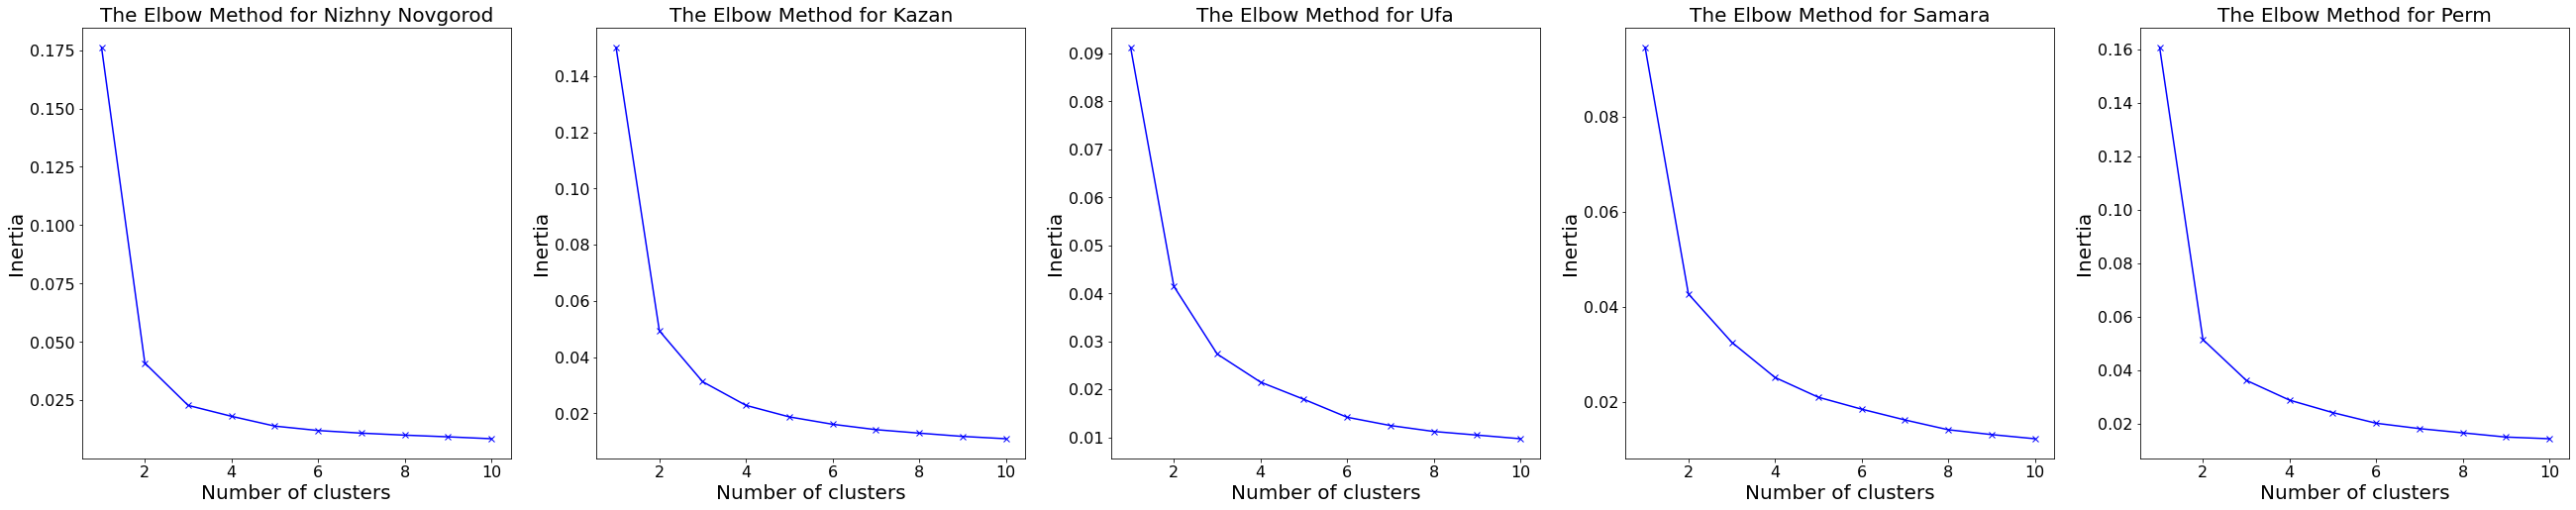

In [20]:
fig, axs0 = plt.subplots(1, number_of_cities, figsize=(45,8))
for city_index in range(number_of_cities):
    city_en = cities_en[city_index]
    kmeans_list_inertia = []
    max_clusters = 10
    for i in range(1,max_clusters+1):
        kmeans_list_inertia.append(cluster_city(i, city_en).inertia_)   
    axs = axs0[city_index]
    axs.plot(range(1,max_clusters+1), kmeans_list_inertia, 'bx-')
    axs.set_title('The Elbow Method for '+city_en,fontsize=20)
    axs.set_xlabel('Number of clusters', fontsize=20)
    axs.set_ylabel('Inertia', fontsize=20)
    axs.tick_params(labelsize=16)

After the study, it was decided to use k = 4 clusters for all the cities. Let us define now the function returning top-N most common venues for each neighborhood in a city (useful for a further visual analysis)

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    result_common = []
    if len(row_categories_sorted.index.values)<num_top_venues:
        result_common = list(row_categories_sorted.index.values[0:len(row_categories_sorted.index.values)])
        for i in range(len(row_categories_sorted.index.values),num_top_venues):
            result_common.append('none')
    else:
        result_common = row_categories_sorted.index.values[0:num_top_venues]
    return result_common

Let us now define the function creating the folium map of the city associating also the clusters for each neighborhood in a city. 

In [22]:
def create_map_clustered(city, df_city,latitude,longitude, kclusters, radius=1000):
    # create map
    map_clusters = folium.Map(width=500,height=500,location=[latitude, longitude], zoom_start=10)
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    #rainbow = [colors.rgb2hex(i) for i in colors_array]
    mycolors = ['red','green','blue','magenta','yellow','cyan','black']
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_city['Latitude'], df_city['Longitude'], df_city['Postal Code'], df_city['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=mycolors[cluster],
            fill=True,
            fill_color=mycolors[cluster],
            fill_opacity=0.7).add_to(map_clusters)
    return map_clusters

Let us cluster all the cities by Kmeans using k = 4 clusters:

In [23]:
kmeans_dict = {}
for city_index in range(number_of_cities):
    city_en = cities_en[city_index]
    kclusters = 4
    kmeans_dict[city_en] = cluster_city(kclusters, city_en)       

## Results <a name="results"></a>

Let us find the top-3 venue categories for each neighborhood within each cluster in each city. Then, let us create the dictionary cities_merged containing all the available information about the venues for each neighborhood in each city including the assigned cluster number.

In [24]:
num_top_venues = 3
indicators = ['st', 'nd', 'rd']
venues_sorted_dict = {}
cities_merged = {}
columns = ['Neighborhood']
    # create columns according to number of top venues
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
for city_index in range(number_of_cities):
    city = cities[city_index]
    city_en = cities_en[city_index]
    # create a new dataframe
    venues_sorted_dict[city_en] = pd.DataFrame(columns=columns)
    venues_sorted_dict[city_en]['Neighborhood'] = grouped_dict[city_en]['Neighborhood']
    df_for_common = onehot_dict[city_en].groupby('Neighborhood').sum().reset_index()
    for ind in np.arange(grouped_dict[city_en].shape[0]):
        venues_sorted_dict[city_en].iloc[ind, 1:] = return_most_common_venues(df_for_common.iloc[ind, :], num_top_venues)
    venues_sorted_dict[city_en].insert(0, 'Cluster Labels', kmeans_dict[city_en].labels_)
    #print(venues_sorted_dict[city_en].head())
    cities_merged[city] = df_collection_cities[city] 
    # merge cities_merged with df to add latitude/longitude for each neighborhood
    cities_merged[city] = cities_merged[city].join(venues_sorted_dict[city_en].set_index('Neighborhood'), on='Postal Code')
    #print(cities_merged[city])
    cities_merged[city].drop(cities_merged[city][cities_merged[city]['Cluster Labels'].isnull()].index,inplace = True)
    cities_merged[city].reset_index(drop = True, inplace = True)
    cities_merged[city]['Cluster Labels'] = cities_merged[city]['Cluster Labels'].astype(int)
    if 'index' in list(cities_merged[city].columns):
        cities_merged[city].drop('index',axis=1,inplace=True)

Create and visualize the maps of the clustered cities. Each map is saved as an element of the list maps_cities and can be displayed during the further research.

In [25]:
maps_cities = []
for city_index in range(number_of_cities):
    city_en = cities[city_index]
    latitude = df_cities_coordinates.loc[city_index,'Latitude']
    longitude = df_cities_coordinates.loc[city_index,'Longitude']
    maps_cities.append(create_map_clustered(city_en, cities_merged[city_en],latitude,longitude, kclusters))
    display(maps_cities[city_index])

Visualize the top-3 venue categories for each neighborhood within each cluster in each city:

In [26]:
for city_n in range(number_of_cities):
    city = cities[city_n]
    city_en = cities_en[city_n]
    print('==================================\n')
    print(city_en+':\n')
    for cluster in range(kclusters):
        print('==================================\n')
        print('cluster '+str(cluster)+':\n')
        display(cities_merged[city].loc[cities_merged[city]['Cluster Labels'] == cluster, cities_merged[city].columns[[0] + list(range(4, cities_merged[city].shape[1]))]])
        print('==================================\n')
    #maps_cities[0]



Nizhny Novgorod:


cluster 0:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,603001,Food,Arts & Entertainment,Nightlife Spot
5,603005,Food,Arts & Entertainment,Nightlife Spot
7,603008,Food,Arts & Entertainment,Nightlife Spot
24,603040,Food,Arts & Entertainment,Nightlife Spot
50,603082,Food,Arts & Entertainment,Nightlife Spot
67,603109,Food,Nightlife Spot,Arts & Entertainment




cluster 1:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,603000,Food,Shop & Service,Travel & Transport
6,603006,Food,Shop & Service,Outdoors & Recreation
15,603024,Food,Shop & Service,Outdoors & Recreation
91,603155,Food,Shop & Service,Outdoors & Recreation
97,603950,Food,Shop & Service,Arts & Entertainment




cluster 2:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,603002,Shop & Service,Food,Travel & Transport
3,603003,Food,Shop & Service,Outdoors & Recreation
4,603004,Food,Shop & Service,Outdoors & Recreation
12,603016,Shop & Service,Outdoors & Recreation,Food
14,603022,Shop & Service,Food,Travel & Transport
34,603057,Shop & Service,Food,Travel & Transport
46,603073,Shop & Service,Travel & Transport,Outdoors & Recreation
49,603079,Shop & Service,Food,Outdoors & Recreation
52,603086,Shop & Service,Food,Travel & Transport
54,603089,Shop & Service,Food,Travel & Transport




cluster 3:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
8,603009,Shop & Service,Travel & Transport,Outdoors & Recreation
9,603010,Travel & Transport,Shop & Service,Outdoors & Recreation
10,603011,Travel & Transport,Shop & Service,Outdoors & Recreation
11,603014,Shop & Service,Outdoors & Recreation,Travel & Transport
13,603018,Travel & Transport,Shop & Service,Outdoors & Recreation
16,603028,Arts & Entertainment,Travel & Transport,Outdoors & Recreation
17,603029,Shop & Service,Travel & Transport,Outdoors & Recreation
18,603032,Shop & Service,Outdoors & Recreation,Travel & Transport
19,603033,Outdoors & Recreation,Travel & Transport,Shop & Service
20,603034,Shop & Service,Travel & Transport,Food




Kazan:


cluster 0:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
4,420008,Food,Nightlife Spot,Arts & Entertainment
7,420014,Food,Arts & Entertainment,Nightlife Spot
9,420017,Food,Arts & Entertainment,Nightlife Spot
65,420111,Food,Arts & Entertainment,Nightlife Spot




cluster 1:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
6,420012,Food,Outdoors & Recreation,Arts & Entertainment
8,420015,Food,Outdoors & Recreation,Shop & Service
10,420021,Food,Outdoors & Recreation,Arts & Entertainment
20,420043,Food,Shop & Service,Nightlife Spot
31,420060,Food,Outdoors & Recreation,Arts & Entertainment
62,420107,Food,Shop & Service,Arts & Entertainment




cluster 2:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
16,420034,Shop & Service,Food,Outdoors & Recreation
21,420044,Shop & Service,Food,Outdoors & Recreation
34,420066,Food,Shop & Service,Outdoors & Recreation
44,420080,Shop & Service,Food,Outdoors & Recreation
53,420097,Food,Shop & Service,Outdoors & Recreation
56,420100,Shop & Service,Food,Outdoors & Recreation
59,420103,Food,Shop & Service,Travel & Transport
64,420110,Shop & Service,Food,Outdoors & Recreation
66,420124,Food,Shop & Service,Outdoors & Recreation
67,420126,Shop & Service,Food,Outdoors & Recreation




cluster 3:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,420000,Outdoors & Recreation,Travel & Transport,Shop & Service
1,420004,Shop & Service,Travel & Transport,Food
2,420005,Shop & Service,Travel & Transport,Outdoors & Recreation
3,420006,Shop & Service,Travel & Transport,Arts & Entertainment
5,420011,Food,Outdoors & Recreation,Travel & Transport
11,420025,Shop & Service,Food,Travel & Transport
12,420029,Shop & Service,Travel & Transport,Arts & Entertainment
13,420030,Travel & Transport,Outdoors & Recreation,Shop & Service
14,420032,Shop & Service,Outdoors & Recreation,Travel & Transport
15,420033,Shop & Service,Travel & Transport,Food




Ufa:


cluster 0:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
8,450008,Food,Shop & Service,Arts & Entertainment
11,450013,Food,Shop & Service,Nightlife Spot
27,450037,Food,Shop & Service,Arts & Entertainment
35,450052,Food,Shop & Service,Arts & Entertainment
54,450076,Food,Shop & Service,Outdoors & Recreation
55,450077,Food,Shop & Service,Arts & Entertainment




cluster 1:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,450001,Shop & Service,Food,Outdoors & Recreation
2,450002,Shop & Service,Food,Outdoors & Recreation
5,450005,Shop & Service,Food,Outdoors & Recreation
6,450006,Shop & Service,Food,Outdoors & Recreation
9,450009,Shop & Service,Food,Arts & Entertainment
12,450015,Shop & Service,Food,Outdoors & Recreation
16,450022,Shop & Service,Food,Arts & Entertainment
36,450053,Food,Shop & Service,Outdoors & Recreation
37,450054,Food,Shop & Service,Outdoors & Recreation
41,450058,Shop & Service,Food,Arts & Entertainment




cluster 2:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,450000,Travel & Transport,Shop & Service,Outdoors & Recreation
7,450007,Travel & Transport,Shop & Service,Outdoors & Recreation
30,450040,Travel & Transport,Outdoors & Recreation,Shop & Service
32,450044,Shop & Service,Food,Travel & Transport
33,450047,Shop & Service,Food,Travel & Transport
40,450057,Outdoors & Recreation,Travel & Transport,Arts & Entertainment
44,450062,Shop & Service,Travel & Transport,Outdoors & Recreation
46,450064,Shop & Service,Food,Travel & Transport
50,450071,Shop & Service,Food,Outdoors & Recreation
51,450073,Shop & Service,Food,Arts & Entertainment




cluster 3:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
3,450003,Shop & Service,Travel & Transport,Outdoors & Recreation
4,450004,Outdoors & Recreation,Travel & Transport,Shop & Service
10,450010,Travel & Transport,Shop & Service,Outdoors & Recreation
13,450017,Shop & Service,Outdoors & Recreation,Arts & Entertainment
14,450018,Shop & Service,Food,Travel & Transport
15,450019,Travel & Transport,Shop & Service,Outdoors & Recreation
17,450024,Shop & Service,Travel & Transport,Outdoors & Recreation
18,450026,Shop & Service,Outdoors & Recreation,Nightlife Spot
19,450027,Shop & Service,Travel & Transport,Nightlife Spot
20,450028,Travel & Transport,Shop & Service,Outdoors & Recreation




Samara:


cluster 0:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
7,443010,Food,Nightlife Spot,Shop & Service
68,443099,Food,Shop & Service,Travel & Transport




cluster 1:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,443001,Food,Shop & Service,Outdoors & Recreation
2,443003,Food,Shop & Service,Outdoors & Recreation
4,443006,Food,Shop & Service,Outdoors & Recreation
14,443020,Food,Shop & Service,Nightlife Spot
36,443054,Food,Shop & Service,Outdoors & Recreation
47,443071,Food,Outdoors & Recreation,Shop & Service
66,443096,Food,Shop & Service,Outdoors & Recreation
69,443100,Food,Shop & Service,Outdoors & Recreation




cluster 2:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
6,443009,Shop & Service,Food,Outdoors & Recreation
8,443011,Shop & Service,Food,Travel & Transport
10,443013,Shop & Service,Food,Outdoors & Recreation
20,443030,Shop & Service,Food,Travel & Transport
23,443034,Shop & Service,Food,Travel & Transport
26,443041,Food,Shop & Service,Travel & Transport
29,443045,Shop & Service,Food,Nightlife Spot
37,443056,Food,Shop & Service,Outdoors & Recreation
43,443067,Shop & Service,Food,Arts & Entertainment
44,443068,Food,Shop & Service,Arts & Entertainment




cluster 3:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,443000,Shop & Service,Food,Outdoors & Recreation
3,443004,Travel & Transport,Shop & Service,Outdoors & Recreation
5,443008,Shop & Service,Food,Outdoors & Recreation
9,443012,Nightlife Spot,Food,Travel & Transport
11,443015,Food,Travel & Transport,Shop & Service
12,443016,Shop & Service,Food,Outdoors & Recreation
13,443017,Shop & Service,Travel & Transport,Outdoors & Recreation
15,443022,Shop & Service,Travel & Transport,Food
16,443023,Food,Shop & Service,Outdoors & Recreation
17,443026,Shop & Service,Outdoors & Recreation,Food




Perm:


cluster 0:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,614000,Food,Shop & Service,Nightlife Spot
2,614006,Food,Nightlife Spot,Shop & Service
25,614039,Food,Shop & Service,Outdoors & Recreation
52,614096,Food,Shop & Service,Nightlife Spot
61,614880,Food,Shop & Service,Nightlife Spot




cluster 1:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,614002,Food,Shop & Service,Outdoors & Recreation
3,614007,Food,Shop & Service,Outdoors & Recreation
4,614010,Food,Shop & Service,Arts & Entertainment
8,614016,Food,Shop & Service,Arts & Entertainment
27,614045,Food,Shop & Service,Outdoors & Recreation
41,614068,Food,Shop & Service,Nightlife Spot
44,614081,Shop & Service,Food,Nightlife Spot
63,614990,Food,Shop & Service,Nightlife Spot




cluster 2:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
9,614017,Food,Shop & Service,Outdoors & Recreation
12,614022,Food,Shop & Service,Travel & Transport
22,614036,Food,Shop & Service,Travel & Transport
28,614046,Food,Shop & Service,Outdoors & Recreation
30,614051,Shop & Service,Food,Outdoors & Recreation
36,614060,Food,Shop & Service,Outdoors & Recreation
39,614066,Shop & Service,Food,Travel & Transport
42,614070,Food,Shop & Service,Arts & Entertainment
43,614077,Shop & Service,Food,Outdoors & Recreation
46,614087,Shop & Service,Outdoors & Recreation,Food




cluster 3:



,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
5,614012,Shop & Service,Travel & Transport,Outdoors & Recreation
6,614013,Travel & Transport,Food,Arts & Entertainment
7,614014,Shop & Service,Travel & Transport,Outdoors & Recreation
10,614018,Travel & Transport,Outdoors & Recreation,Shop & Service
11,614021,Shop & Service,Food,Outdoors & Recreation
13,614023,Travel & Transport,Shop & Service,Nightlife Spot
14,614025,Shop & Service,Travel & Transport,Outdoors & Recreation
15,614026,Shop & Service,Travel & Transport,Outdoors & Recreation
16,614029,Shop & Service,Travel & Transport,Food
17,614030,Shop & Service,Outdoors & Recreation,Food


Let us visualize now the box plots of the relative number of venues of each neighborhood within each cluster in each city (similarly to the box plots created before for Nizhny Novgorod) in order to study for the biases and correct clustering:

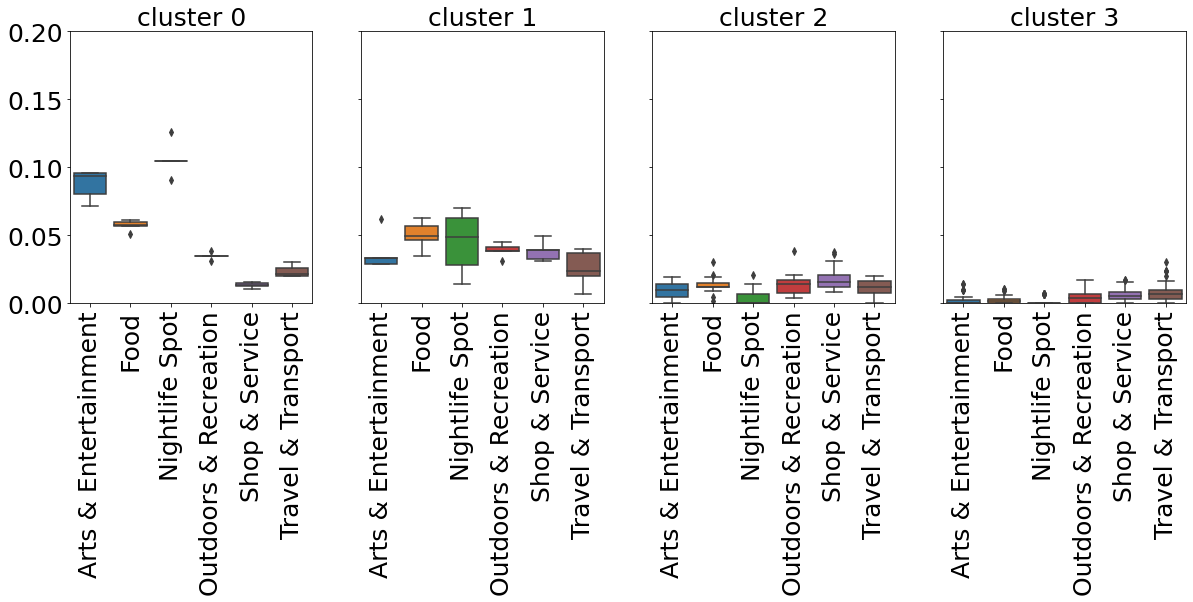

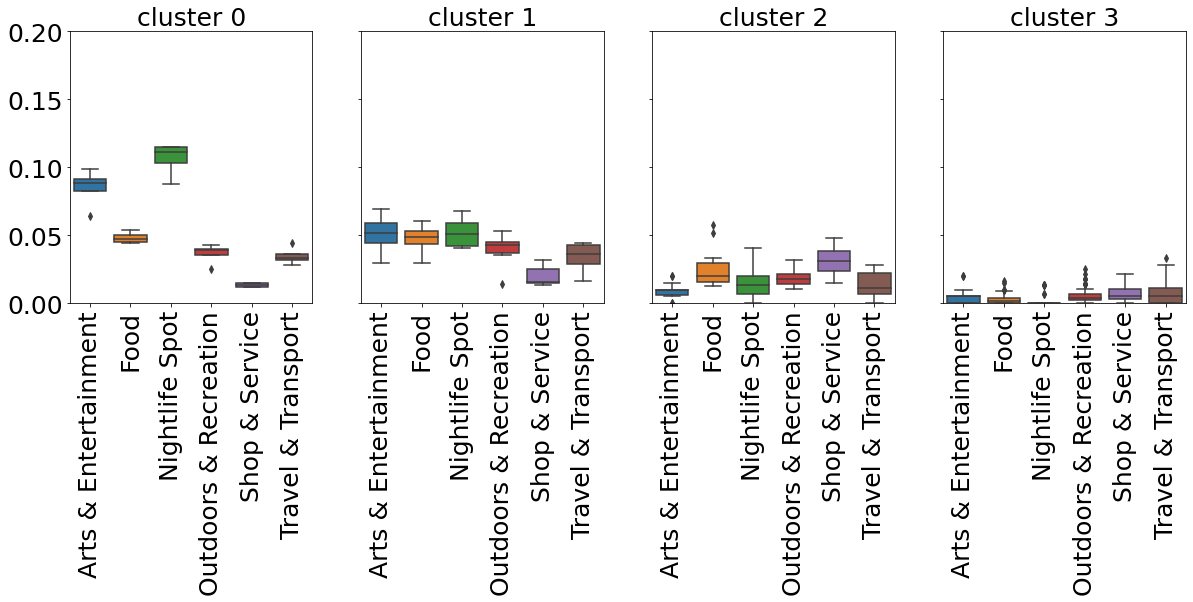

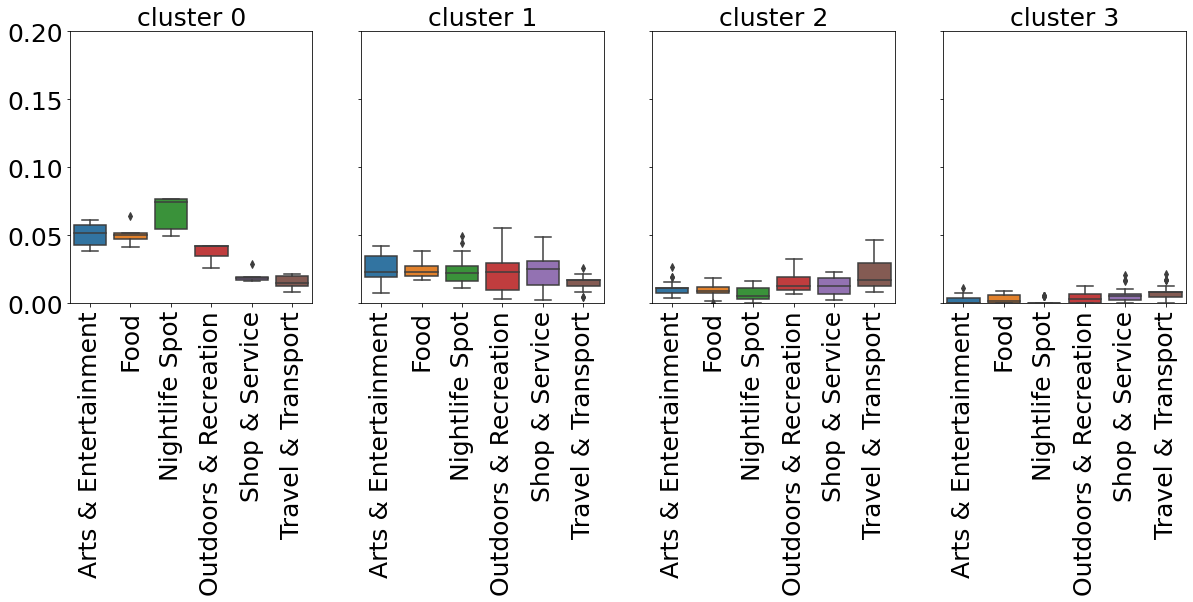

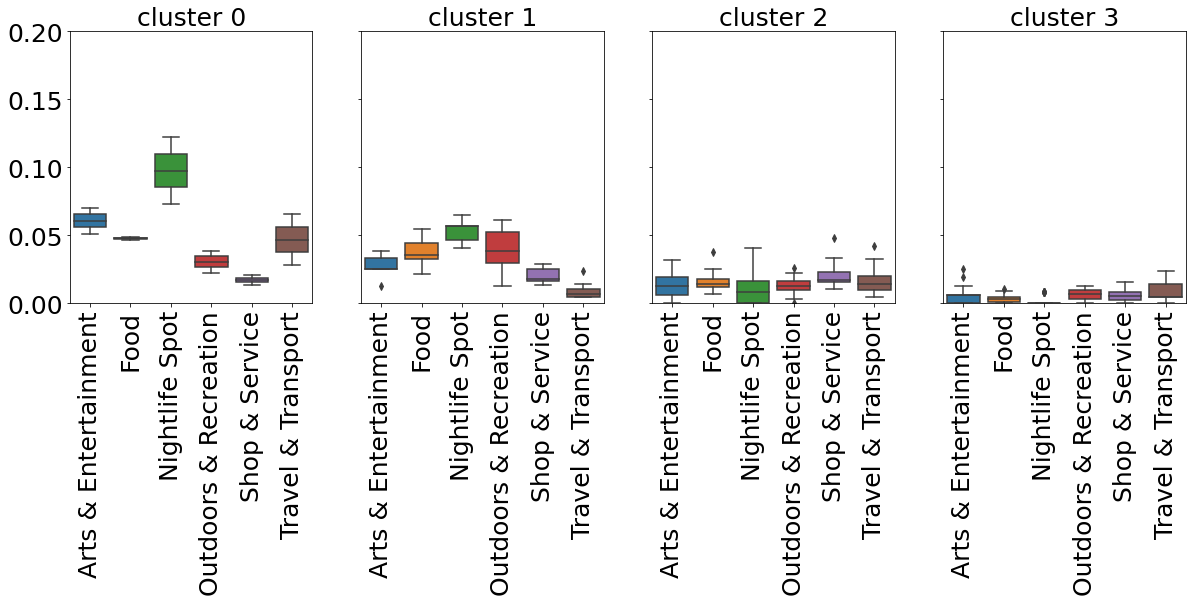

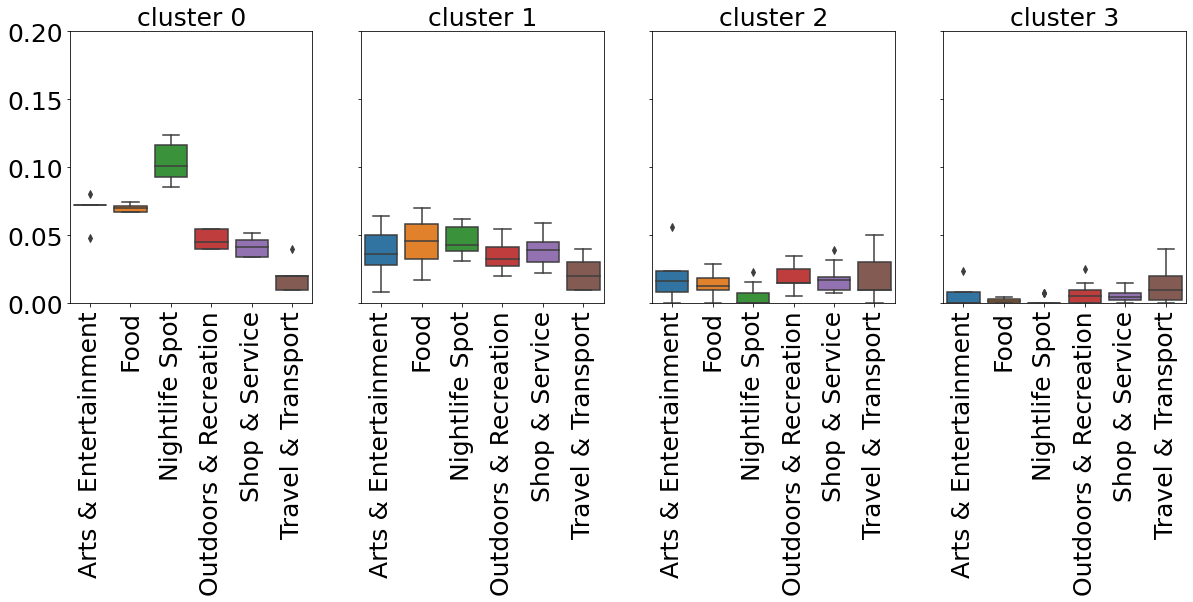

In [27]:
for city_n in range(number_of_cities):
    fig, axs = plt.subplots(1,kclusters,figsize = (20,5))
    for i in range(kclusters):
        df = grouped_dict[cities_en[city_n]].loc[cities_merged[cities[city_n]]['Cluster Labels'] == i]
        df = df[['Arts & Entertainment','Food','Nightlife Spot', 'Outdoors & Recreation','Shop & Service','Travel & Transport']]
        fbox = sns.boxplot(data = df,ax = axs[i])
        axs[i].set_title('cluster '+str(i),fontsize = 25)
        axs[i].set_ylim([0,0.2])
        if i>0:
            fbox.set(yticklabels=[])
        axs[i].tick_params(axis = 'x',labelsize=25,rotation=90)
        axs[i].tick_params(axis = 'y',labelsize=25,rotation=0)

We can see that there are much less biases now (except several categories for Cluster 1 in Kazan and Cluster 0 in Ufa. So, the clustering is acceptable. However, one can decide if the clusters 0 and 1 should be unified, since they contain less neighborhoods w.r.t. Clusters 2 and 3, and they both are located at the city centers. However, Cluster 0 is related to the old city centers, while Cluster 1 is related to the modern parts of the city centers. 

Let us visualize now the distributions of the venue categories within each cluster (in percents) for each city:

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Venue Category,,,,
Arts & Entertainment,18.77,8.69,6.33,4.07
Food,40.27,38.31,30.35,17.84
Nightlife Spot,15.53,7.13,1.86,1.56
Outdoors & Recreation,10.24,12.47,13.97,15.18
Shop & Service,8.02,24.94,35.38,37.09
Travel & Transport,7.17,8.46,12.10,24.26


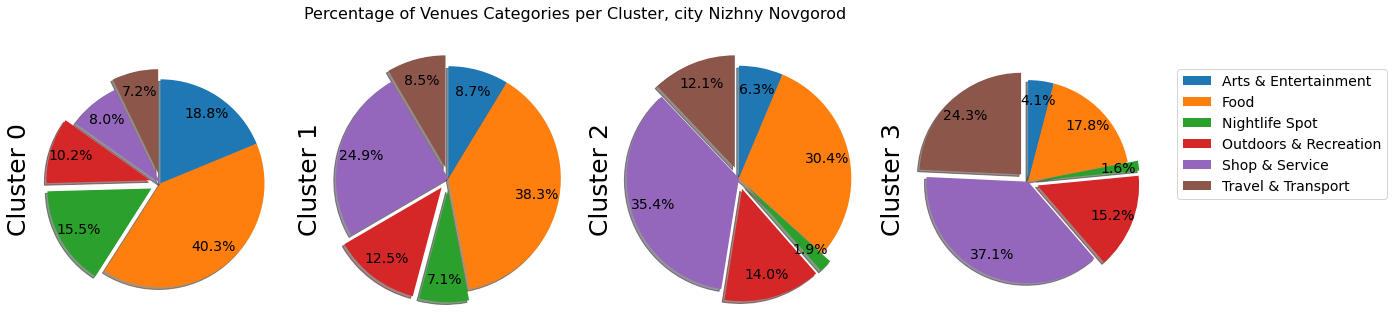

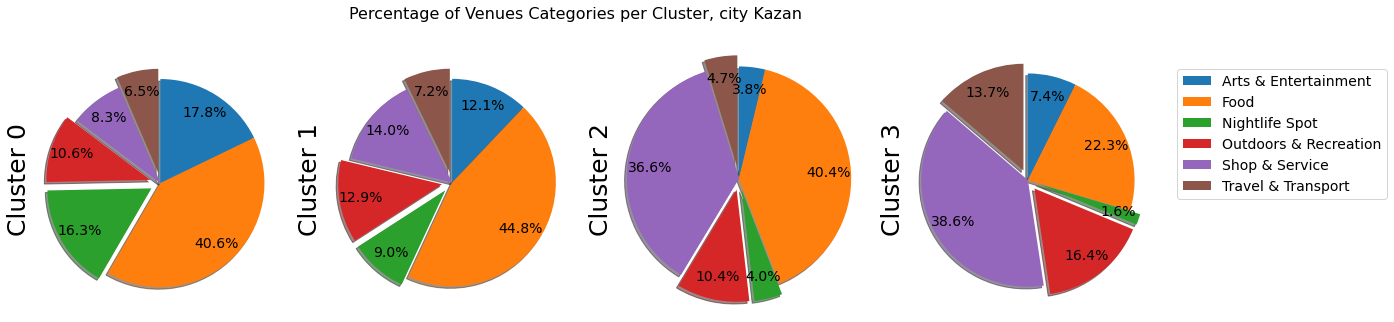

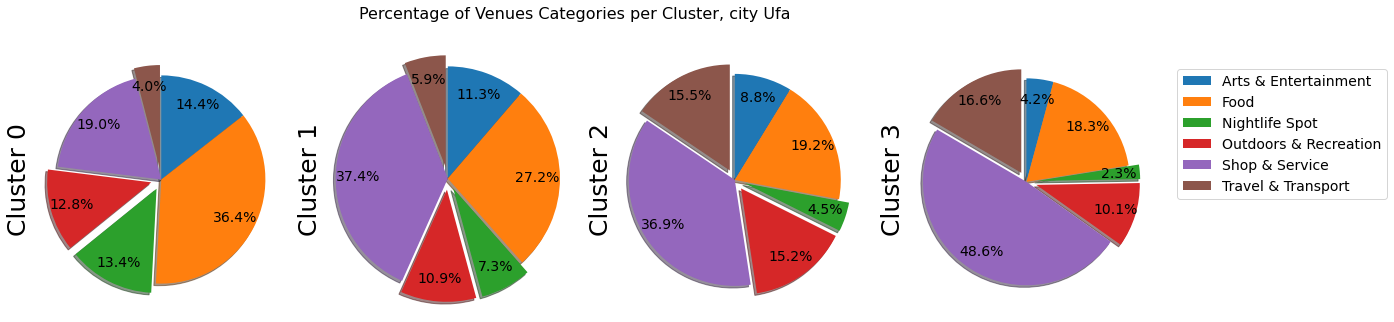

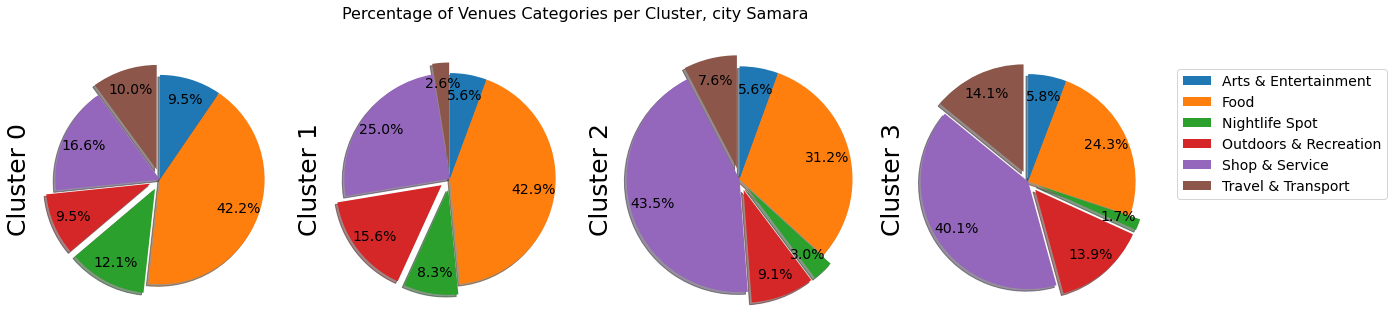

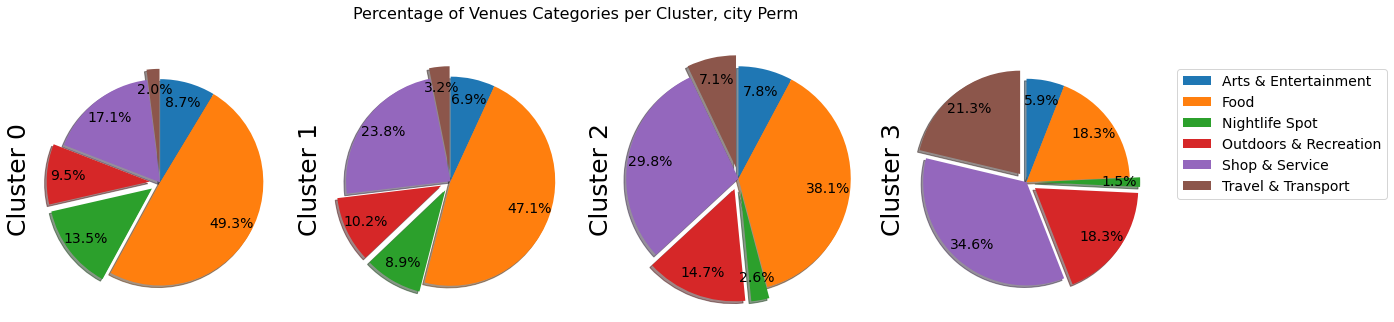

In [28]:
df1 = pd.DataFrame()
mydf_per100_dict = {}
for city_n in range(5):
    df1 = pd.DataFrame(columns = ['Venue Category', 'Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
    df1['Venue Category'] = ['Arts & Entertainment','Food','Nightlife Spot', 'Outdoors & Recreation','Shop & Service','Travel & Transport']
    df1.set_index('Venue Category',inplace = True)
    for i in range(kclusters):
        df1.loc[:,'Cluster '+str(i)] = onehot_dict[cities_en[city_n]].groupby('Neighborhood').sum().reset_index().drop('Neighborhood',axis = 1, inplace = False).loc[cities_merged[cities[city_n]]['Cluster Labels'] == i].sum()
    num_total_0 = pd.DataFrame(df1.sum()).transpose()
    mydf_per100_dict[cities_en[city_n]] = df1
    for rows in df1.index:
        mydf_per100_dict[cities_en[city_n]].loc[rows] = round(100*df1.loc[rows]/num_total_0.iloc[0],2)
    #################
    explode_list = [0., 0., 0.1, 0.1, 0., 0.1] # ratio for each continent with which to offset each wedge.
    fig,axs = plt.subplots(1,kclusters,figsize = (20,5))
    plt.suptitle('Percentage of Venues Categories per Cluster, city '+cities_en[city_n],size = 16)
    for i_cluster in range(kclusters):
        mydf_per100_dict[cities_en[city_n]]['Cluster '+str(i_cluster)].plot(kind='pie', figsize=(40, 10),subplots = True,autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=0.8,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            explode=explode_list,counterclock=False,fontsize = 14,ax = axs[i_cluster])
        axs[i_cluster].axis('equal')
        axs[i_cluster].set_ylabel('Cluster '+str(i_cluster), fontsize=25)
    axs[-1].legend(labels=mydf_per100_dict[cities_en[city_n]].index, loc='lower right', fontsize = 14,bbox_to_anchor=(2, 0.4))
mydf_per100_dict[cities_en[0]]
    
    

## Discussion <a name="discussion"></a>

Let us calculate now the root mean square deviations with respect to Nizhny Novgorod of the obtained percentage distributions within each cluster (the smallest rms value is indicated by red for each cluster):

In [29]:
df_temp_dist = pd.DataFrame(columns = ['City','Cluster 0','Cluster 1','Cluster 2','Cluster 3'])
for i in range(kclusters): 
    df1 = pd.DataFrame(columns = ['Venue Category']+cities_en[0:5])
    df1['Venue Category'] = ['Arts & Entertainment','Food','Nightlife Spot', 'Outdoors & Recreation','Shop & Service','Travel & Transport']
    df1.set_index('Venue Category',inplace = True)
    for city_n in range(5):
        df1[cities_en[city_n]] = mydf_per100_dict[cities_en[city_n]]['Cluster '+str(i)]
    for city_n in range(1,5):
        x = np.array(list(df1[cities_en[city_n]]-df1[cities_en[0]]))
        df_temp_dist.at[city_n-1,'City'] = cities_en[city_n]
        df_temp_dist.at[city_n-1,'Cluster '+str(i)] = np.sqrt(np.mean(x**2))
df_temp_dist.set_index('City',inplace = True)
df_temp_dist['Average'] = df_temp_dist.mean(axis=1)
def mycolorfun(val):
    if val in list(df_temp_dist.min(axis=0)):
        color = 'red'
    else: 
        color = 'black'
    return 'color: %s' % color
    #return 'background-color: %s' % color
df_temp_dist.style.applymap(mycolorfun, ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Average'])

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Average
City,,,,,
Kazan,0.608988,5.446536,5.481505,4.909425,4.111613
Ufa,5.414327,7.002333,5.053364,6.027620,5.874411
Samara,5.520522,3.557337,4.331435,5.140835,4.637533
Perm,7.045545,4.451563,4.453031,2.174331,4.531118


We see that, according to this criterion, the most similar to Nizhny Novgorod city is Kazan for neighborhoods located in Clusters 0 and 3, Ufa -- for Cluster 2, and Samara -- for Cluster 1

Let us calculate the root mean square deviations of the average relative number of venues for each category w.r.t. Nizhny Novgorod within each cluster. The smallest rms values are indicated by red.

In [30]:
df_temp_dist = pd.DataFrame(columns = ['City','Cluster 0','Cluster 1','Cluster 2','Cluster 3'])
for i in range(kclusters): 
    df1 = pd.DataFrame(columns = ['Venue Category']+cities_en[0:5])
    df1['Venue Category'] = ['Arts & Entertainment','Food','Nightlife Spot', 'Outdoors & Recreation','Shop & Service','Travel & Transport']
    df1.set_index('Venue Category',inplace = True)
    for city_n in range(5):
        df1[cities_en[city_n]] =round(100*pd.DataFrame(grouped_dict[cities_en[city_n]].loc[cities_merged[cities[city_n]]['Cluster Labels'] == i].drop('Neighborhood',axis=1).mean()),2)
    for city_n in range(1,5):
        x = np.array(list(df1[cities_en[city_n]]-df1[cities_en[0]]))
        df_temp_dist.at[city_n-1,'City'] = cities_en[city_n]
        df_temp_dist.at[city_n-1,'Cluster '+str(i)] = np.sqrt(np.mean(x**2))
df_temp_dist.set_index('City',inplace = True)
df_temp_dist['Average'] = df_temp_dist.mean(axis=1)
#display(df_temp_dist)
def mycolorfun(val):
    if val in list(df_temp_dist.min(axis=0)):
        color = 'red'
    else: 
        color = 'black'
    return 'color: %s' % color
    #return 'background-color: %s' % color
display(df_temp_dist.style.applymap(mycolorfun, ['Cluster 0','Cluster 1','Cluster 2','Cluster 3', 'Average']))


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Average
City,,,,,
Kazan,0.609262,1.047903,0.866304,0.133041,0.664128
Ufa,2.269787,1.741474,0.480833,0.060139,1.138058
Samara,1.574283,1.215271,0.445047,0.155724,0.847581
Perm,1.571093,0.326216,0.382862,0.226016,0.626547


We see that, according to the second criterion, the most similar to Nizhny Novgorod city is Samara for neighborhoods located in Clusters 0, 2, and 3, and Ufa -- for Cluster 1.

Finally, let us apply the third criterion and find top-3 most common venue categories for each cluster in each city

In [31]:
display(mydf_per100_dict[cities_en[0]])
df_cities_common = pd.DataFrame(columns = ['City','Cluster 0','Cluster 1','Cluster 2','Cluster 3'])
for i in range(kclusters):
    for city_n in range(number_of_cities):
        df_cities_common.at[city_n,'City'] = cities_en[city_n]
        df_cities_common.at[city_n,'Cluster '+str(i)] = list(mydf_per100_dict[cities_en[city_n]].sort_values(by='Cluster '+str(i),ascending = False).index[0:3])
df_cities_common.set_index('City',inplace=True)
display(df_cities_common)


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Venue Category,,,,
Arts & Entertainment,18.77,8.69,6.33,4.07
Food,40.27,38.31,30.35,17.84
Nightlife Spot,15.53,7.13,1.86,1.56
Outdoors & Recreation,10.24,12.47,13.97,15.18
Shop & Service,8.02,24.94,35.38,37.09
Travel & Transport,7.17,8.46,12.10,24.26


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
City,,,,
Nizhny Novgorod,"[Food, Arts & Entertainment, Nightlife Spot]","[Food, Shop & Service, Outdoors & Recreation]","[Shop & Service, Food, Outdoors & Recreation]","[Shop & Service, Travel & Transport, Food]"
Kazan,"[Food, Arts & Entertainment, Nightlife Spot]","[Food, Shop & Service, Outdoors & Recreation]","[Food, Shop & Service, Outdoors & Recreation]","[Shop & Service, Food, Outdoors & Recreation]"
Ufa,"[Food, Shop & Service, Arts & Entertainment]","[Shop & Service, Food, Arts & Entertainment]","[Shop & Service, Food, Travel & Transport]","[Shop & Service, Food, Travel & Transport]"
Samara,"[Food, Shop & Service, Nightlife Spot]","[Food, Shop & Service, Outdoors & Recreation]","[Shop & Service, Food, Outdoors & Recreation]","[Shop & Service, Food, Travel & Transport]"
Perm,"[Food, Shop & Service, Nightlife Spot]","[Food, Shop & Service, Outdoors & Recreation]","[Food, Shop & Service, Outdoors & Recreation]","[Shop & Service, Travel & Transport, Food]"


In [32]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [33]:
num_top = 3
df_jaccard_total = pd.DataFrame(columns = ['City','Cluster 0','Cluster 1','Cluster 2','Cluster 3'])
for city_n in range(1,number_of_cities):
    df_jaccard_total.at[city_n-1,'City'] = cities_en[city_n]
    #display(jaccard(list(df_cities_common.iloc[city_n]),list(df_cities_common.iloc[0])))
    for i in range(kclusters):
        df_jaccard_total.at[city_n-1,'Cluster '+str(i)] = jaccard(list(df_cities_common.iloc[city_n])[i],list(df_cities_common.iloc[0])[i])
df_jaccard_total['Average'] = df_jaccard_total.drop('City',axis=1,inplace=False).mean(axis=1)
df_jaccard_total.set_index('City',inplace=True)
def mycolorfun(val):
    if val in list(df_jaccard_total.max(axis=0)):
        color = 'red'
    else: 
        color = 'black'
    return 'color: %s' % color
df_jaccard_total.style.applymap(mycolorfun, ['Average'])

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Average
City,,,,,
Kazan,1.000000,1.000000,1.000000,0.500000,0.875000
Ufa,0.500000,0.500000,0.500000,1.000000,0.625000
Samara,0.500000,1.000000,1.000000,1.000000,0.875000
Perm,0.500000,1.000000,1.000000,1.000000,0.875000


We see that, according to this criterion, Kazan, Samara, and Perm are equally similar to Nizhny Novgorod. Let us now calculate different similarity indices for the cities based on the number of neighborhoods in each cluster:

In [34]:
#nji is the number of samples in city j, cluster i
nji = pd.DataFrame()
for city_n in range(number_of_cities):
    nji.at[city_n,'City'] = cities_en[city_n]
    for i in range(kclusters):
        nji.at[city_n,'Cluster '+str(i)] = cities_merged[cities[city_n]].loc[cities_merged[cities[city_n]]['Cluster Labels']==i].shape[0]
nji.set_index('City',inplace=True)
nji['Total'] = nji.sum(axis=1)
df_similarity = pd.DataFrame() #(columns = ['City', 'Bray and Curtis', 'Bray and Curtis (log)', 'Canberra metric', 'Squared Euclidean distance', 'Morista index', 'Simplified Morista index'])
#Bray and Curtis similarity index:
BC_sim = []
#Bray and Curtis similarity index after logarithmic transformation:
BC_sim_log = []
#Canberra metric:
CM_sim = []
#Squared Euclidean distance:
SED_sim = []
#Morista index:
MI_sim = []
#Simplified Morista index:
MI_sim_simple = []
df_similarity['City'] = cities_en[1:5]
for city_n in range(1,number_of_cities):
    
    nji1 = np.array(list(nji.iloc[0,0:4]))#/nji.iloc[0,4]
    Nj1 = nji.iloc[0,4]
    nji2 = np.array(list(nji.iloc[city_n,0:4]))#/nji.iloc[city_n,4]
    Nj2 = nji.iloc[city_n,4]
    nji_diff = nji1-nji2
    nji_sum = nji1+nji2
    BC_sim.append(1-(np.abs(nji_diff).sum())/nji_sum.sum())
    BC_sim_log.append(1-(np.abs(np.log(nji1+1)-np.log(nji2+1)).sum())/(np.log(nji1+1)+np.log(nji2+1)).sum())
    CM_sim.append(1-(1/kclusters)*(np.abs(nji_diff)/nji_sum).sum())
    SED_sim.append(1-((nji1/Nj1-nji2/Nj2)**2).sum())
    lambda_1 = (nji1*(nji1-1)).sum()/(Nj1*(Nj1-1))
    lambda_2 = (nji2*(nji2-1)).sum()/(Nj2*(Nj2-1))
    MI_sim.append((2*(nji1*nji2).sum())/((lambda_1+lambda_2)*Nj1*Nj2))
    lambda_1 = (nji1**2).sum()/(Nj1**2)
    lambda_2 = (nji2**2).sum()/(Nj2**2)
    MI_sim_simple.append((2*(nji1*nji2).sum())/((lambda_1+lambda_2)*Nj1*Nj2))
df_similarity['Bray and Curtis'] = BC_sim
df_similarity['Bray and Curtis (log)'] = BC_sim_log
df_similarity['Canberra Metric'] = CM_sim
df_similarity['Squared Euclidean distance'] = SED_sim
df_similarity['Morisita index'] = MI_sim
df_similarity['Simplified Morisita index'] = MI_sim_simple
df_similarity.set_index('City',inplace=True)

def mycolorfun(val):
    if val in list(df_similarity.max(axis=0)):
        color = 'red'
    else: 
        color = 'black'
    return 'color: %s' % color
df_similarity.style.applymap(mycolorfun)

,Bray and Curtis,Bray and Curtis (log),Canberra Metric,Squared Euclidean distance,Morisita index,Simplified Morisita index
City,,,,,,
Kazan,0.877778,0.954826,0.866495,0.999150,1.009178,0.999207
Ufa,0.715909,0.916262,0.768784,0.895599,0.893019,0.878816
Samara,0.765027,0.900998,0.706925,0.943633,0.952931,0.941298
Perm,0.743902,0.937598,0.824342,0.954763,0.965999,0.950675


At this moment, we see that according to all similarity indices Kazan is the most similar to Nizhny Novgorod. 

Let us now define the function creating the clustered map of a city, where only the best places for a restaurant are shown. For each selected neighborhood, the number of cluster, number of food venues and number of non-food venues are shown.

In [35]:
def create_map_clustered_best(df_city,latitude_init,longitude_init, kclusters, radius=1000):
    # create map
    map_clusters = folium.Map(width=800,height=800,location=[latitude_init, longitude_init], zoom_start=11)
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    #rainbow = [colors.rgb2hex(i) for i in colors_array]
    mycolors = ['red','green','blue','magenta','yellow','cyan','black']
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster, sum_venues,sum_nonfood_venues in zip(df_city['Latitude'], df_city['Longitude'], df_city['Neighborhood'], df_city['Cluster Labels'], df_city['Sum of Food Venues'],df_city['Sum of Non-Food Venues']):
        label = folium.Popup(str(poi) + ' Cluster' + str(cluster) +' '+ 'Food_Venues:'+str(sum_venues)+' '+'NonFood_Venues:'+str(sum_nonfood_venues), parse_html=True, fontsize = 50)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=mycolors[cluster],
            fill=True,
            fill_color=mycolors[cluster],
            fill_opacity=0.7).add_to(map_clusters)
    return map_clusters

Let us now define the function for determining the best neighborhoods for placing a restaurant within each cluster in a city. 

1. First, for each neighborhood within each cluster, the number of food venues and the number of non-food venues are calculated.
2. Then, the unique numbers of food venues are calculated for each cluster and then ordered in an ascending order. The Q1-quartile of them is taken (let us denote it as top_n, different for each cluster)
3. For each cluster, take only the neighborhoods having less than top_n food venues. 
4. Order the obtained venues by the number of non-food venues in each cluster in a descending order. 
5. Take top-3 neighborhoods from the obtained list for each cluster.

In [36]:
def divide_categories_in_city(city_en,city_ru):
    ### This part of the code can be made much simpler, but I decided to reload all the venues starting from the micro categories, 
    ### since in practice there can be necessary to calculate not the number of food and non-food venues, but, e.g., the number of sushi-bars, non-sushi food venues, non-food venues.
    ### So, for this reason, in order to simplify future modifications, we will reload all the venues information into all_venues dataframe, 
    ### then perform one hot encoding and group the neighborhoods summing their number of food and non-food venues.
    
    filename = city_en+'_venues.csv'
    body = client_1e7ffed86c124ea785256df61c776ec6.get_object(Bucket='courseraibmdscapstoneproject-donotdelete-pr-d45ghpa6lf5uhv',Key=filename)['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
    all_venues = pd.read_csv(body,header = 0)
    all_venues['Neighborhood']=all_venues['Neighborhood'].astype(str)
    all_venues.drop_duplicates(subset=list(all_venues.columns)[1:], keep='first', inplace=True)
    all_venues.reset_index(inplace = True)
    print('There are {} unique categories in {}.'.format(len(all_venues['Venue Category'].unique()),city_en))
    onehot = pd.DataFrame()
    onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")
    # add neighborhood column back to dataframe
    onehot['Neighborhood'] = all_venues['Neighborhood'] 
    # move neighborhood column to the first column
    ind_nei = onehot.columns.tolist().index('Neighborhood');
    fixed_columns = [onehot.columns[ind_nei]]+list(onehot.columns[0:ind_nei])+list(onehot.columns[ind_nei+1:])
    onehot = onehot[fixed_columns]
    print('Shape of the onehot dataframe: ', onehot.shape)
    grouped = onehot.groupby('Neighborhood').sum().reset_index()
    selected_columns = []
    unselected_columns = []
    macro_cat_id = list(main_categories[main_categories['name']=='Food'].index)[0]
    for col in list(grouped.columns):
        if col in main_categories_dict[macro_cat_id]:
            selected_columns.append(col)
        else:
            unselected_columns.append(col)
    grouped.insert(0, 'Cluster Labels', kmeans_dict[city_en].labels_)
    grouped['Cluster Labels'] = grouped['Cluster Labels'].astype(int)
    grouped_topN = pd.DataFrame()
    for cluster in range(kclusters):
        new_df = grouped.loc[grouped['Cluster Labels']==cluster]
        #print(new_df.shape)
        new_df = new_df[selected_columns].sum(axis = 1)
        new_df_sorted = np.sort(list(set(new_df)))
        top_n = int(len(new_df_sorted)*0.25)
        if top_n<2:
            top_n = 2
        if len(new_df_sorted)<3:
            top_n = len(new_df_sorted)-1
        grouped['Sum of Food Venues'] = grouped[selected_columns].sum(axis = 1)
        grouped['Sum of Non-Food Venues'] = grouped[unselected_columns].sum(axis = 1)
        grouped_topN_temp = pd.DataFrame(grouped.iloc[new_df[new_df<=new_df_sorted[top_n]].index][['Neighborhood','Sum of Food Venues','Sum of Non-Food Venues']])
        grouped_topN_temp.sort_values(by = 'Sum of Non-Food Venues',ascending = False,inplace = True)
        grouped_topN = grouped_topN.append(grouped_topN_temp.iloc[0:3])
    grouped_topN = grouped_topN.join(cities_merged[city_ru].set_index('Postal Code'),on = 'Neighborhood')
    print('Shape of the grouped dataframe:', grouped.shape)
    city_index = list(df_cities_coordinates.loc[df_cities_coordinates['city']==city_en].index)[0]
    latitude = df_cities_coordinates.loc[city_index,'Latitude']
    longitude = df_cities_coordinates.loc[city_index,'Longitude']
    best_map = create_map_clustered_best(grouped_topN,latitude,longitude, kclusters, radius=1000)
    return grouped_topN,best_map


In [37]:
for city_n in range(1,number_of_cities):
    grouped_best, map_best = divide_categories_in_city(cities_en[city_n],cities[city_n])
    print('The best neighborhoods for placing a restaurant in ',cities_en[city_n],':')
    grouped_best.set_index('Neighborhood',inplace=True)
    display(grouped_best)
    display(map_best)

There are 241 unique categories in Kazan.
Shape of the onehot dataframe:  (2262, 242)
Shape of the grouped dataframe: (80, 245)
The best neighborhoods for placing a restaurant in  Kazan :


,Sum of Food Venues,Sum of Non-Food Venues,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Neighborhood,,,,,,,,
420014,36,64,55.796878,49.108822,0,Food,Arts & Entertainment,Nightlife Spot
420017,37,63,55.798551,49.106324,0,Food,Arts & Entertainment,Nightlife Spot
420111,40,60,55.793351,49.112408,0,Food,Arts & Entertainment,Nightlife Spot
420107,34,54,55.779228,49.131082,1,Food,Shop & Service,Arts & Entertainment
420021,24,43,55.779342,49.112822,1,Food,Outdoors & Recreation,Arts & Entertainment
420043,39,39,55.782064,49.144244,1,Food,Shop & Service,Nightlife Spot
420133,12,31,55.830835,49.157022,2,Shop & Service,Food,Travel & Transport
420140,14,31,55.767897,49.231726,2,Shop & Service,Food,Travel & Transport
420044,12,28,55.832822,49.095629,2,Shop & Service,Food,Outdoors & Recreation


There are 195 unique categories in Ufa.
Shape of the onehot dataframe:  (2544, 196)
Shape of the grouped dataframe: (76, 199)
The best neighborhoods for placing a restaurant in  Ufa :


,Sum of Food Venues,Sum of Non-Food Venues,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Neighborhood,,,,,,,,
450077,33,64,54.726091,55.948193,0,Food,Shop & Service,Arts & Entertainment
450008,33,63,54.724787,55.949341,0,Food,Shop & Service,Arts & Entertainment
450076,27,53,54.727615,55.932553,0,Food,Shop & Service,Outdoors & Recreation
450006,13,50,54.743821,55.961681,1,Shop & Service,Food,Outdoors & Recreation
450096,11,39,54.759567,56.012980,1,Shop & Service,Food,Arts & Entertainment
450022,12,37,54.718293,55.993954,1,Shop & Service,Food,Arts & Entertainment
450091,3,30,54.746615,55.954654,2,Travel & Transport,Outdoors & Recreation,Shop & Service
450000,1,21,54.749521,55.947344,2,Travel & Transport,Shop & Service,Outdoors & Recreation
450007,0,18,54.750750,55.946861,2,Travel & Transport,Shop & Service,Outdoors & Recreation


There are 230 unique categories in Samara.
Shape of the onehot dataframe:  (2668, 230)
Shape of the grouped dataframe: (83, 233)
The best neighborhoods for placing a restaurant in  Samara :


,Sum of Food Venues,Sum of Non-Food Venues,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Neighborhood,,,,,,,,
443099,41,58,53.182876,50.085220,0,Food,Shop & Service,Travel & Transport
443010,43,57,53.192330,50.097231,0,Food,Nightlife Spot,Shop & Service
443096,25,47,53.200366,50.137031,1,Food,Shop & Service,Outdoors & Recreation
443100,30,44,53.210288,50.125609,1,Food,Shop & Service,Outdoors & Recreation
443003,19,37,53.215733,50.139756,1,Food,Shop & Service,Outdoors & Recreation
443115,9,28,53.261824,50.224433,2,Shop & Service,Food,Travel & Transport
443076,10,26,53.187356,50.197718,2,Shop & Service,Food,Outdoors & Recreation
443081,7,25,53.230206,50.214579,2,Shop & Service,Food,Outdoors & Recreation
443117,1,10,53.187881,50.207210,3,Travel & Transport,Shop & Service,Outdoors & Recreation


There are 211 unique categories in Perm.
Shape of the onehot dataframe:  (1676, 211)
Shape of the grouped dataframe: (64, 214)
The best neighborhoods for placing a restaurant in  Perm :


,Sum of Food Venues,Sum of Non-Food Venues,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Neighborhood,,,,,,,,
614006,47,53,58.010725,56.232251,0,Food,Nightlife Spot,Shop & Service
614039,47,53,57.999019,56.250269,0,Food,Shop & Service,Outdoors & Recreation
614096,49,51,58.008365,56.225425,0,Food,Shop & Service,Nightlife Spot
614068,22,33,58.006669,56.204408,1,Food,Shop & Service,Nightlife Spot
614081,12,31,57.997854,56.213012,1,Shop & Service,Food,Nightlife Spot
614010,23,24,57.988634,56.249074,1,Food,Shop & Service,Arts & Entertainment
614087,4,19,57.993774,56.195985,2,Shop & Service,Outdoors & Recreation,Food
614111,0,14,57.973154,56.234902,2,Shop & Service,Outdoors & Recreation,Travel & Transport
614107,2,12,58.026320,56.299813,2,Outdoors & Recreation,Shop & Service,Food


## Conclusion <a name="conclusion"></a>

Five biggest cities of the Volga Federal District have been studied in this research. For each city, the neighborhoods based on the postal code have been subdivided into 4 clusters: 
1. neighborhoods in the old city center (Cluster 0), 
2. neighborhoods in the modern city center (Cluster 1), 
3. neighborhoods outside of the center (Cluster 2), 
4. outskirts of the city (Cluster 3). 

There have been identified 3 criteria for the comparison of the cities based on the obtained results. Future study is possible only with a collaboration with the stakeholders restricting and understanding their requirements: e.g., if the stakeholders are interested in a particular particular of the city (e.g., the old city center) and the similarity of distributions of the venue categories is the most useful criterion for them, then a particular city becomes the best (in this case: Kazan). If a concrete numeric metric is required for estimating similarities between the cities, then, e.g., different similarity indices can be also used. In this case, according to the most widely used similarity indices, the most similar city to Nizhny Novgorod is Kazan. A more strict collaboration with the stakeholders will improve the obtained accuracy and restrict the obtained results.

Important conclusions can be made observing the obtained results. 

First, the studied cities are very similar: they have a strict old city center, a modern city center, a developing part of the city with more transport and service venues, and, finally, outskirts with a low number of venues. 

Second, it has been obtained that the Foursquare API does not provide all necessary information about the cities. Moreover, some important venues are not presented in the Foursquare, since the cities are not touristy, being distant from the main touristic venues or cities. Foursquare API can be more reasonable to use for studying bigger or more touristic cities, e.g., Moscow or Saint Petersburg. For example, there is a big multiplex cinema 'Karo Film Rossiya' around the postal code '603076' in Nizhny Novgorod, but Foursquare did not find it: 

`all_venues_dict['Nizhny Novgorod'].loc[all_venues_dict['Nizhny Novgorod']['Neighborhood']=='603076']`

For a more precise analysis, it can be more reasonable to use other APIs (possibly, integrating their results with the ones obtained by Foursquare), for example, Google or Yandex. Yandex is a russian company providing Internet-related products and services, including transportation, search and information services. It is very similar to Google, but provides the most actual and full information about venues in russian cities. However, at this moment, it does not provide any free instrument for study of venues in russian cities as well as Google, so I decided to use Foursquare only for now. But, since Yandex grows very fast, being the largest IT company in Russia (see, e.g., the following link) with a rapidly growing service Yandex.map and particular interest to Machine Learning and Data Science, it is already clear that it will be used for the analogous study in the near future, probably, together with Foursquare and/or Google. 


In [38]:
all_venues_dict['Nizhny Novgorod'].loc[all_venues_dict['Nizhny Novgorod']['Neighborhood']=='603076']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Micro Category,Venue Category
1152,603076,56.288332,43.931412,МясновЪ,56.287461,43.943879,Food & Drink Shop,Shop & Service
1153,603076,56.288332,43.931412,Салон-магазин МТС,56.287226,43.928618,Electronics Store,Shop & Service
1154,603076,56.288332,43.931412,Бульвар Заречный,56.285857,43.931140,Pedestrian Plaza,Outdoors & Recreation
1155,603076,56.288332,43.931412,Макдоналдс,56.284369,43.928875,Fast Food Restaurant,Food
1156,603076,56.288332,43.931412,Эльдорадо,56.287361,43.928367,Electronics Store,Shop & Service
1157,603076,56.288332,43.931412,Пятерочка,56.291889,43.921205,Supermarket,Shop & Service
1158,603076,56.288332,43.931412,Spar,56.282015,43.922740,Grocery Store,Shop & Service
1159,603076,56.288332,43.931412,"Фонтан перед гостиницей ""Заречная""",56.285201,43.928681,Fountain,Outdoors & Recreation
1160,603076,56.288332,43.931412,Станция метро «Заречная»,56.284349,43.927916,Metro Station,Travel & Transport
1161,603076,56.288332,43.931412,"Ресторан ""Уют""",56.295824,43.939418,Café,Food
